#가설1. 경험치 기반 성장효율X이탈

##전처리

In [ ]:
# =========================================
# 0. 라이브러리 & 폰트
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# =========================================
# 1. 데이터 로딩 & 기본 전처리
# =========================================

df = pd.read_csv("growth_log_v2_f_v2.csv", parse_dates=["date"])

df = df[["ocid", "date", "character_level", "character_exp", "access_flag"]].dropna()
df["character_level"] = pd.to_numeric(df["character_level"], errors="coerce")
df["character_exp"]   = pd.to_numeric(df["character_exp"], errors="coerce")
df = df.dropna()

df = df.sort_values(["ocid","date"])

# access_flag → active
def to_bool(x):
    if pd.isna(x): return False
    if isinstance(x,str):
        s=x.strip().lower()
        if s in ["true","1","y","yes","t"]: return True
        if s in ["false","0","n","no","f"]: return False
    try: return bool(int(x))
    except: return False

df["active"] = df["access_flag"].apply(to_bool).astype(int)

# EXP 변화량
df["exp_diff"] = df.groupby("ocid")["character_exp"].diff().fillna(0)
df.loc[df["exp_diff"] < 0, "exp_diff"] = 0

# 4주 성장률
df["growth_4w"] = (
    df.groupby("ocid")["exp_diff"]
      .rolling(window=4, min_periods=1).mean()
      .reset_index(level=0, drop=True)
)

# 레벨 구간
bins=[260,265,270,275,10**6]
labels=["260-264","265-269","270-274","275+"]
df["level_group"] = pd.cut(df["character_level"], bins=bins, labels=labels, right=False)


# =========================================
# 2. C안: 로그 기반 정규화 효율 계산
# =========================================
avg = (
    df.groupby(["date","level_group"], observed=True)["growth_4w"]
      .mean()
      .rename("avg_growth")
)

df = df.merge(avg, on=["date","level_group"], how="left")

df["eff"] = np.log1p(df["growth_4w"]) - np.log1p(df["avg_growth"].clip(lower=1e-6))


# =========================================
# 3. 패널 생성 & 영구 이탈 라벨링
# =========================================

df["week"] = df["date"].dt.isocalendar().week.astype(int)

panel = (
    df[["ocid","week","date","active","eff","level_group"]]
      .dropna(subset=["level_group"])
      .drop_duplicates(["ocid","week"])
      .sort_values(["ocid","week"])
)

def persistent_from_week(s_active):
    a = s_active.to_numpy().astype(int)
    n = len(a)
    out = np.zeros(n, dtype=int)
    still0=True
    for i in range(n-1, -1, -1):
        if a[i] == 1:
            still0 = False
        if a[i] == 0 and still0:
            out[i] = 1
    return pd.Series(out, index=s_active.index)

panel["churn_future"] = (
    panel.groupby("ocid")["active"]
          .apply(persistent_from_week)
          .reset_index(level=0, drop=True)
)

# 유저별 최종 이탈 라벨
churn_flag = panel.groupby("ocid")["churn_future"].max().astype(int)


# =========================================
# 4. 최근 8주 기반 스냅샷
# =========================================

snapshot_date = df['date'].max()
start_date = snapshot_date - pd.Timedelta(weeks=7)

df_win = df[(df['date'] >= start_date) & (df['date'] <= snapshot_date)].copy()
df_win['weeks_from_start'] = ((df_win['date'] - start_date).dt.days // 7).astype(int)

def agg_user(g):
    eff = g['eff'].values
    if len(eff) == 0:
        return pd.Series({
            'eff_mean_8w': np.nan, 'eff_std_8w': np.nan,
            'eff_slope_8w': np.nan, 'stagnation_ratio_8w': np.nan
        })
    x = g['weeks_from_start'].values.astype(float)
    if len(eff) > 1 and np.ptp(x) > 0:
        x_center = x - x.mean()
        slope = np.polyfit(x_center, eff, 1)[0]
    else:
        slope = 0.0

    return pd.Series({
        'eff_mean_8w': eff.mean(),
        'eff_std_8w': eff.std(ddof=0),
        'eff_slope_8w': slope,
        'stagnation_ratio_8w': np.mean(eff < 0)  # 로그정규화 기준
    })

df_snap = df_win.groupby("ocid").apply(agg_user)

df_snap["label"] = df_snap.index.map(churn_flag).fillna(0).astype(int)

last_lg = (
    df.sort_values(["ocid","date"])
      .groupby("ocid").tail(1)
      .set_index("ocid")["level_group"]
)

df_snap["level_group"] = df_snap.index.map(last_lg)

df_snap = df_snap.reset_index()

print(df_snap.head())

                               ocid  eff_mean_8w  eff_std_8w  eff_slope_8w  \
0  001d0f7171bf3a62f5b2f04c1e7a93cb    -6.578454    9.208693      1.066426   
1  001e51e7b5575d34bf33ef98d9799f16   -25.757934    0.536066      0.226766   
2  004a8e007b27ad1fa1dc7e836991ec15     0.353558    0.616699      0.235222   
3  00a87a8b17854233aac80ea802be42bb     0.803838    0.185286      0.022015   
4  01169d5649332f7ace03f240ec394c4d    -0.731924    0.803480     -0.105363   

   stagnation_ratio_8w  label level_group  
0                1.000      1        275+  
1                1.000      1     270-274  
2                0.375      0        275+  
3                0.000      0        275+  
4                0.875      0        275+  


/tmp/ipython-input-944764690.py:123: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_snap = df_win.groupby("ocid").apply(agg_user)


##EDA

In [ ]:
# 1) 라이브러리 & 폰트
!apt-get update -qq
!apt-get install -qq fonts-nanum
!pip install koreanize_matplotlib

import koreanize_matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 폰트 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
plt.rcParams["font.family"] = "NanumGothic"
plt.rcParams["axes.unicode_minus"] = False

# seaborn 스타일
sns.set(font="NanumGothic", rc={"axes.unicode_minus": False})

print(">>> NanumGothic 폰트 적용 완료!")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
>>> NanumGothic 폰트 적용 완료!


       eff_mean_log  eff_std_log  eff_slope_8w  stagnation_ratio_8w
count    353.000000   904.000000    904.000000           911.000000
mean      -0.038184     1.039334      0.329514             0.710569
std        0.806996     0.983963      3.574282             0.369865
min       -5.090365     0.000000     -5.480374             0.000000
25%       -0.352558     0.273456     -0.285162             0.375000
50%        0.102224     0.517000      0.018296             1.000000
75%        0.527157     2.251344      0.226766             1.000000
max        1.157162     2.751554     29.007959             1.000000
label
0    0.535675
1    0.464325
Name: proportion, dtype: float64


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


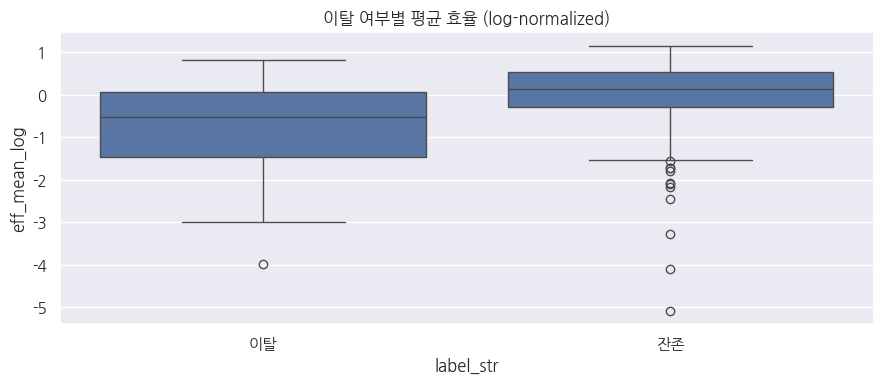

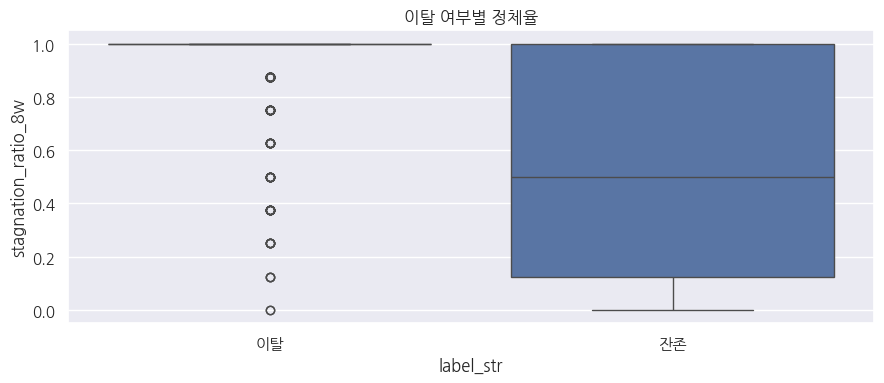

/tmp/ipython-input-1819503642.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  st_rate = df_eda.groupby("stagn_bin")["label"].mean().mul(100).reset_index(name="churn_rate")


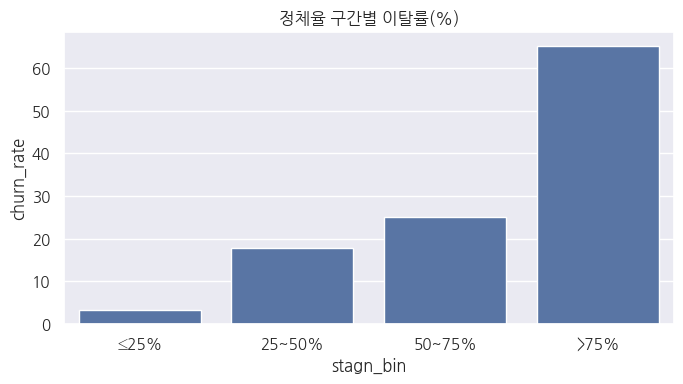

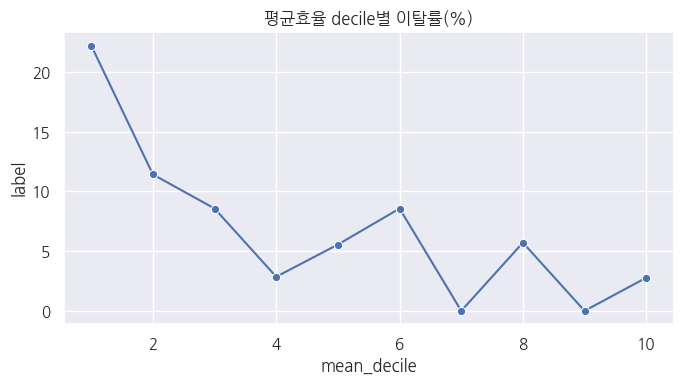

/tmp/ipython-input-1819503642.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=df_eda.groupby("level_group")["label"].mean().mul(100).reset_index(),


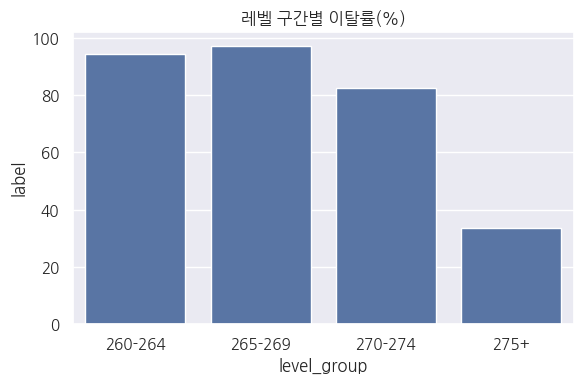

In [ ]:
# =========================================
# EDA 0. 복사본 생성 + 전처리
# =========================================

df_eda = df_snap.copy()

# -----------------------
# winsorizing (상/하위 0.1% 절단)
# -----------------------
clip_cols = ["eff_mean_8w", "eff_std_8w", "eff_slope_8w"]

for c in clip_cols:
    q_low  = df_eda[c].quantile(0.001)
    q_high = df_eda[c].quantile(0.999)
    df_eda[c] = df_eda[c].clip(q_low, q_high)

# -----------------------
# log-transform (효율만)
# -----------------------
df_eda["eff_mean_log"] = np.log1p(df_eda["eff_mean_8w"])
df_eda["eff_std_log"]  = np.log1p(df_eda["eff_std_8w"])
# slope는 양/음 모두 가능 → log 변환 X

# label 텍스트 컬럼
df_eda["label_str"] = df_eda["label"].map({0:"잔존", 1:"이탈"})

# =========================================
# EDA 1. 기본 통계
# =========================================
print(df_eda.describe()[["eff_mean_log", "eff_std_log", "eff_slope_8w", "stagnation_ratio_8w"]])
print(df_eda["label"].value_counts(normalize=True))

# =========================================
# EDA 2. 로그효율 / 정체율 박스플롯
# =========================================

plt.figure(figsize=(9,4))
sns.boxplot(data=df_eda, x="label_str", y="eff_mean_log")
plt.title("이탈 여부별 평균 효율 (log-normalized)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
sns.boxplot(data=df_eda, x="label_str", y="stagnation_ratio_8w")
plt.title("이탈 여부별 정체율")
plt.tight_layout()
plt.show()

# =========================================
# EDA 3. 정체율 구간별 이탈률
# =========================================

bins_st = [0, 0.25, 0.5, 0.75, 1.01]
labels_st = ["≤25%","25~50%","50~75%",">75%"]

df_eda["stagn_bin"] = pd.cut(df_eda["stagnation_ratio_8w"], bins=bins_st, labels=labels_st, right=False)

st_rate = df_eda.groupby("stagn_bin")["label"].mean().mul(100).reset_index(name="churn_rate")

plt.figure(figsize=(7,4))
sns.barplot(data=st_rate, x="stagn_bin", y="churn_rate")
plt.title("정체율 구간별 이탈률(%)")
plt.tight_layout()
plt.show()

# =========================================
# EDA 4. decile 선그래프
# =========================================

df_eda["mean_decile"] = pd.qcut(df_eda["eff_mean_log"].rank(method="first"), 10, labels=False)

mean_curve = df_eda.groupby("mean_decile")["label"].mean().mul(100).reset_index()
mean_curve["mean_decile"] = mean_curve["mean_decile"] + 1

plt.figure(figsize=(7,4))
sns.lineplot(data=mean_curve, x="mean_decile", y="label", marker="o")
plt.title("평균효율 decile별 이탈률(%)")
plt.tight_layout()
plt.show()

# =========================================
# EDA 5. 레벨 그룹별 이탈률
# =========================================
plt.figure(figsize=(6,4))
sns.barplot(data=df_eda.groupby("level_group")["label"].mean().mul(100).reset_index(),
            x="level_group", y="label")
plt.title("레벨 구간별 이탈률(%)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3000626221.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["stagn_bin", "slope_bin"])["label"]


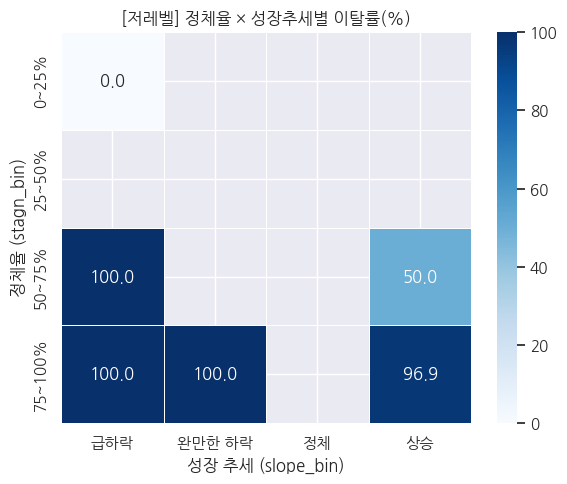

/tmp/ipython-input-3000626221.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["stagn_bin", "slope_bin"])["label"]


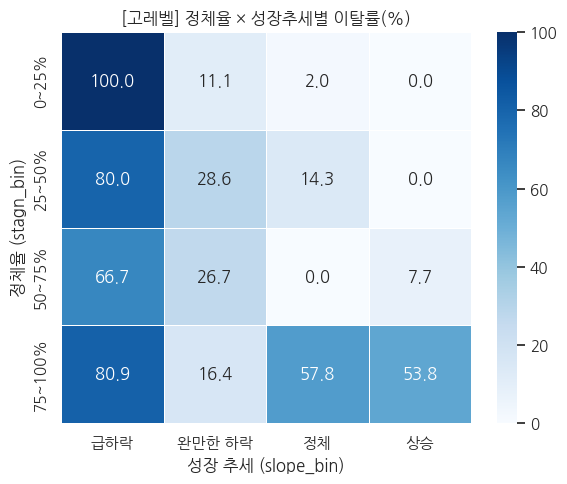

In [ ]:
# ---------------------------------------------------
# 추가 EDA ① 레벨별 (stagnation × slope) 이탈률 히트맵
# ---------------------------------------------------

# 레벨 묶기: 260~269 = 저레벨, 270~275+ = 고레벨
df_snap["level_group2"] = df_snap["level_group"].map({
    "260-264": "저레벨",
    "265-269": "저레벨",
    "270-274": "고레벨",
    "275+":    "고레벨"
})

# 성장 추세 구간
bins_slope   = [-999, -0.3, -0.05, 0.05, 999]
labels_slope = ["급하락", "완만한 하락", "정체", "상승"]

df_snap["slope_bin"] = pd.cut(
    df_snap["eff_slope_8w"],
    bins=bins_slope,
    labels=labels_slope,
    right=True
)

# 정체율 구간
bins_st   = [0, 0.25, 0.5, 0.75, 1.01]
labels_st = ["0~25%", "25~50%", "50~75%", "75~100%"]

df_snap["stagn_bin"] = pd.cut(
    df_snap["stagnation_ratio_8w"],
    bins=bins_st,
    labels=labels_st,
    right=False
)

import seaborn as sns
import matplotlib.pyplot as plt

def draw_heatmap(df, title):
    pivot = (
        df.groupby(["stagn_bin", "slope_bin"])["label"]
          .mean()
          .mul(100)
          .reset_index()
          .pivot(index="stagn_bin", columns="slope_bin", values="label")
    )

    plt.figure(figsize=(6,5))
    sns.heatmap(
        pivot, annot=True, fmt=".1f", cmap="Blues",
        vmin=0, vmax=100, linewidths=.5, cbar=True
    )
    plt.title(title)
    plt.xlabel("성장 추세 (slope_bin)")
    plt.ylabel("정체율 (stagn_bin)")
    plt.tight_layout()
    plt.show()

# 저레벨
df_low = df_snap[df_snap["level_group2"] == "저레벨"]
draw_heatmap(df_low, "[저레벨] 정체율 × 성장추세별 이탈률(%)")

# 고레벨
df_high = df_snap[df_snap["level_group2"] == "고레벨"]
draw_heatmap(df_high, "[고레벨] 정체율 × 성장추세별 이탈률(%)")


/tmp/ipython-input-1038943466.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"first_stagn_week": first_stagn_week(g)}))


                               ocid  first_stagn_week  label label_str
0  001d0f7171bf3a62f5b2f04c1e7a93cb               0.0      1        이탈
1  001e51e7b5575d34bf33ef98d9799f16               0.0      1        이탈
2  004a8e007b27ad1fa1dc7e836991ec15               0.0      0        잔존
3  00a87a8b17854233aac80ea802be42bb               0.0      0        잔존
4  01169d5649332f7ace03f240ec394c4d               1.0      0        잔존


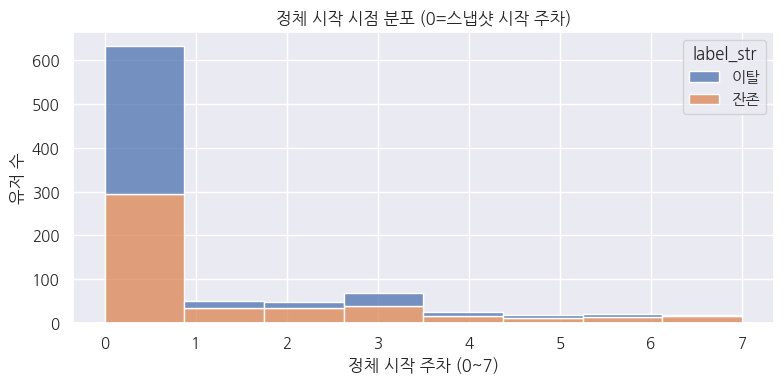

In [ ]:
# ---------------------------------------------------
# 추가 EDA ② 정체가 시작된 시점 히스토그램
#   - 0 = 스냅샷 시작 주차
#   - 0~7 사이 값 (최근 8주 기준)
# ---------------------------------------------------

THRESH = 0.6  # 정체 기준 효율 (이미 위에서 쓰던 값과 동일하게)

# 1) 8주 윈도우 데이터에서 '정체 여부' 플래그 붙이기
df_stagn = df_win.copy()
df_stagn["is_stagn"] = (df_stagn["eff"] < THRESH).astype(int)

# 2) 유저별로 "처음 정체가 시작된 주차" 계산
def first_stagn_week(g):
    # 정체인 주차만 필터
    stagn_weeks = g.loc[g["is_stagn"] == 1, "weeks_from_start"]
    if len(stagn_weeks) == 0:
        return np.nan  # 정체가 한 번도 없으면 NaN
    return stagn_weeks.min()

df_timing = (
    df_stagn
      .groupby("ocid")
      .apply(lambda g: pd.Series({"first_stagn_week": first_stagn_week(g)}))
      .reset_index()
)

# 3) 유저 이탈 라벨/텍스트 붙이기 (df_snap에서 가져옴)
df_timing = df_timing.merge(
    df_snap[["ocid", "label"]],
    on="ocid",
    how="left"
)

# 정체가 아예 없는 유저는 이번 그래프에서는 제외
df_timing = df_timing.dropna(subset=["first_stagn_week", "label"])

# label_str 생성 (이걸 안 만들었어서 에러났던 거!)
df_timing["label_str"] = df_timing["label"].map({0: "잔존", 1: "이탈"})

print(df_timing.head())

# 4) 이탈자/잔존자 비교 히스토그램
plt.figure(figsize=(8,4))
sns.histplot(
    data=df_timing,
    x="first_stagn_week",
    hue="label_str",
    multiple="stack",
    bins=8
)
plt.title("정체 시작 시점 분포 (0=스냅샷 시작 주차)")
plt.xlabel("정체 시작 주차 (0~7)")
plt.ylabel("유저 수")
plt.tight_layout()
plt.show()


/tmp/ipython-input-48250106.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_first_stagnation)


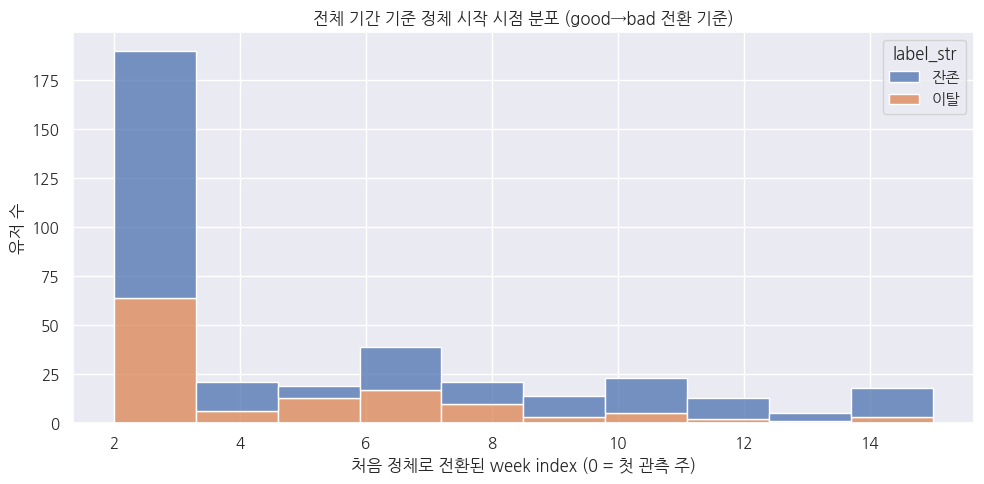

In [ ]:
# ---------------------------------------------------
# 추가 EDA ③ 전체 기간 기준 정체 시작 시점 히스토그램 (good→bad 전환 기준)
# ---------------------------------------------------
THRESH = 0.6

def get_first_stagnation(g):
    eff  = g["eff"].to_numpy()
    idx  = g["week_idx"].to_numpy()

    good = eff >= THRESH   # 괜찮은 주
    bad  = eff < THRESH    # 정체로 보는 주

    # 좋은 주도 없거나, 나쁜 주도 없으면 "정체 시작 시점 없음"
    if not good.any() or not bad.any():
        return pd.Series({"first_stagn": np.nan})

    # 지금까지 한 번이라도 good이 있었던 이후에 처음 bad가 되는 지점
    # prefix_good[i] = 0~i 사이에 good이 한 번이라도 있었는지
    prefix_good = np.maximum.accumulate(good)
    candidate   = bad & prefix_good

    if not candidate.any():
        return pd.Series({"first_stagn": np.nan})

    return pd.Series({"first_stagn": idx[candidate].min()})

# 전체 기간 기준 다시 계산
df_all = df.copy().sort_values(["ocid","date"]).reset_index(drop=True)
df_all["week_idx"] = df_all.groupby("ocid").cumcount()

df_first_stagn = (
    df_all.groupby("ocid")
          .apply(get_first_stagnation)
          .reset_index()
)

# churn_flag 붙이기 (없는 애는 제거)
df_first_stagn["label"] = df_first_stagn["ocid"].map(churn_flag)
df_first_stagn = df_first_stagn.dropna(subset=["label"])
df_first_stagn["label"] = df_first_stagn["label"].astype(int)
df_first_stagn["label_str"] = df_first_stagn["label"].map({0:"잔존", 1:"이탈"})

# 정체 시작 시점이 없는 유저는 제외하고 히스토그램
df_plot = df_first_stagn.dropna(subset=["first_stagn"])

plt.figure(figsize=(10,5))
sns.histplot(
    data=df_plot,
    x="first_stagn",
    hue="label_str",
    multiple="stack",
    bins=10
)
plt.title("전체 기간 기준 정체 시작 시점 분포 (good→bad 전환 기준)")
plt.xlabel("처음 정체로 전환된 week index (0 = 첫 관측 주)")
plt.ylabel("유저 수")
plt.tight_layout()
plt.show()


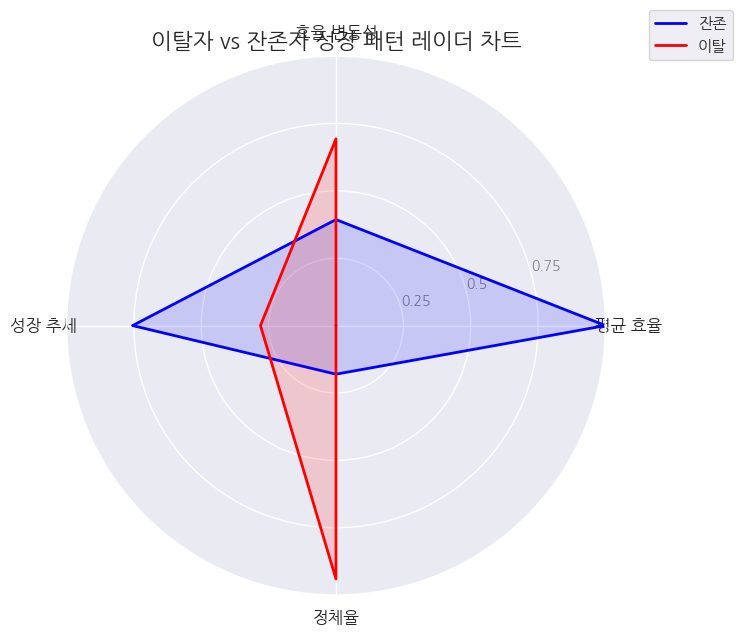

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# 0) 원 데이터에서 복사
df_plot = df_snap.copy()

# 1) 사용할 지표
cols = ["eff_mean_8w", "eff_std_8w", "eff_slope_8w", "stagnation_ratio_8w"]
nice_labels = ["평균 효율", "효율 변동성", "성장 추세", "정체율"]

# 2) label_str 생성
df_plot["label_str"] = df_plot["label"].map({0: "잔존", 1: "이탈"})

# 3) 전체 분포 기준으로 z-score 표준화
for c in cols:
    mu = df_plot[c].mean()
    sigma = df_plot[c].std(ddof=0)
    df_plot[c + "_z"] = (df_plot[c] - mu) / (sigma + 1e-9)

z_cols = [c + "_z" for c in cols]

# 4) 잔존/이탈별 z-score 평균
agg_z = df_plot.groupby("label_str")[z_cols].mean()

# 5) 레이더용 0~1 스케일로 재변환 (음수 방지용 shift)
z_min = agg_z.min().min()
z_max = agg_z.max().max()
agg_norm = (agg_z - z_min) / (z_max - z_min + 1e-9)

# 6) 레이더 차트 그리기
N = len(cols)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

for group, color in zip(["잔존", "이탈"], ["blue", "red"]):
    values = agg_norm.loc[group].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=group, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

# 축/레이블
plt.xticks(angles[:-1], nice_labels, fontsize=12)
ax.set_rlabel_position(15)
plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
plt.ylim(0, 1)

plt.title("이탈자 vs 잔존자 성장 패턴 레이더 차트", fontsize=16)
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))
plt.show()


##모델링

In [ ]:
# =========================================
# 0. 공통: 피처/타깃 준비
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    confusion_matrix, classification_report
)
from xgboost import XGBClassifier
import shap

# df_snap 안에 아래 컬럼이 있다고 가정:
# ['ocid', 'eff_mean_8w', 'eff_std_8w', 'eff_slope_8w',
#  'stagnation_ratio_8w', 'label', 'level_group']

feature_cols = ["eff_mean_8w", "eff_std_8w", "eff_slope_8w", "stagnation_ratio_8w"]

# 1) 모델링용 베이스 DF
df_model = df_snap.dropna(subset=feature_cols + ["label"]).copy()
df_model["label"] = df_model["label"].astype(int)

# (선택) 이상치 살짝 컷 – SHAP/로지스틱 안정화용
for c in ["eff_mean_8w", "eff_std_8w", "eff_slope_8w"]:
    q_low  = df_model[c].quantile(0.001)
    q_high = df_model[c].quantile(0.999)
    df_model[c] = df_model[c].clip(q_low, q_high)

X = df_model[feature_cols]      # 항상 DataFrame 유지!
y = df_model["label"]

# Train / Test Split (stratify로 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train churn ratio:", y_train.mean(), " Test churn ratio:", y_test.mean())


Train size: (723, 4)  Test size: (181, 4)
Train churn ratio: 0.46749654218533887  Test churn ratio: 0.46408839779005523


In [ ]:
# =========================================
# 1. 헬퍼: PR-curve 기반 임계값 계산
# =========================================

def best_thresholds(y_true, proba):
    """
    - F1 기준 High 컷 (t_high)
    - F0.5 기준 Watch 컷 (t_watch)
    - t_watch > t_high면 너무 이상해서 t_watch를 t_high의 절반으로 보정
    """
    precision, recall, thr = precision_recall_curve(y_true, proba)
    thr = np.append(thr, 1.01)  # 길이 맞추기 용

    f1  = (2 * precision * recall) / (precision + recall + 1e-12)
    f05 = (1.25 * precision * recall) / (0.25 * precision + recall + 1e-12)

    t_high  = thr[np.nanargmax(f1)]
    t_watch = thr[np.nanargmax(f05)]

    if t_watch > t_high:
        t_watch = 0.5 * t_high

    return float(t_high), float(t_watch)


In [ ]:
# =========================================
# 2. 로지스틱 회귀 (Pipeline + 티어링)
# =========================================

pipe_logit = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        random_state=42
    ))
])

pipe_logit.fit(X_train, y_train)

proba_logit_test = pipe_logit.predict_proba(X_test)[:, 1]
auc_logit = roc_auc_score(y_test, proba_logit_test)
print(f"[Logistic] Test AUC = {auc_logit:.3f}")

# 계수 / 오즈비 (스케일된 기준)
logit = pipe_logit.named_steps["logit"]
scaler = pipe_logit.named_steps["scaler"]

coef = logit.coef_[0]  # (n_features,)
odds = np.exp(coef)
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coef,
    "odds_ratio": odds
})
print("\n[Logistic 계수 / 오즈비]")
print(coef_df)

# 임계값 & 티어링
t_high_logit, t_watch_logit = best_thresholds(y_test.values, proba_logit_test)
print(f"\n[Logistic 임계값] t_high={t_high_logit:.3f} | t_watch={t_watch_logit:.3f}")

def assign_risk_tier(proba, t_high, t_watch):
    if proba >= t_high:
        return "High"
    elif proba >= t_watch:
        return "Watch"
    else:
        return "Safe"

df_test_logit = df_model.loc[X_test.index].copy()
df_test_logit["proba_logit"]  = proba_logit_test
df_test_logit["risk_tier_lg"] = df_test_logit["proba_logit"].apply(
    lambda p: assign_risk_tier(p, t_high_logit, t_watch_logit)
)

summary_logit = (
    df_test_logit
    .groupby("risk_tier_lg")["label"]
    .agg(count="count", churn_rate=lambda s: s.mean() * 100)
    .reset_index()
)

print("\n[등급별 이탈률(%) - Logistic(Test)]")
print(summary_logit)

# High 컷 기준 이진 분류 성능
y_pred_high_logit = (df_test_logit["proba_logit"] >= t_high_logit).astype(int)

print("\n[Logistic - High 컷 기준 Confusion Matrix]")
print(confusion_matrix(y_test, y_pred_high_logit))
print("\n[Logistic - High 컷 기준 Classification Report]")
print(classification_report(y_test, y_pred_high_logit))


[Logistic] Test AUC = 0.939

[Logistic 계수 / 오즈비]
               feature      coef  odds_ratio
0          eff_mean_8w -1.744795    0.174681
1           eff_std_8w  1.129196    3.093168
2         eff_slope_8w -2.266611    0.103663
3  stagnation_ratio_8w  0.613454    1.846800

[Logistic 임계값] t_high=0.680 | t_watch=0.340

[등급별 이탈률(%) - Logistic(Test)]
  risk_tier_lg  count  churn_rate
0         High     80      93.750
1         Safe     96       9.375
2        Watch      5       0.000

[Logistic - High 컷 기준 Confusion Matrix]
[[92  5]
 [ 9 75]]

[Logistic - High 컷 기준 Classification Report]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        97
           1       0.94      0.89      0.91        84

    accuracy                           0.92       181
   macro avg       0.92      0.92      0.92       181
weighted avg       0.92      0.92      0.92       181



In [ ]:
# =========================================
# 3. XGBoost (Test AUC + 티어링)
# =========================================

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.04,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42,
)

xgb.fit(X_train, y_train)

proba_xgb_test = xgb.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, proba_xgb_test)
print(f"\n[XGBoost] Test AUC = {auc_xgb:.3f}")

t_high_xgb, t_watch_xgb = best_thresholds(y_test.values, proba_xgb_test)
print(f"[XGBoost 임계값] t_high={t_high_xgb:.3f} | t_watch={t_watch_xgb:.3f}")

df_test_xgb = df_model.loc[X_test.index].copy()
df_test_xgb["proba_xgb"]  = proba_xgb_test
df_test_xgb["risk_tier_xgb"] = df_test_xgb["proba_xgb"].apply(
    lambda p: assign_risk_tier(p, t_high_xgb, t_watch_xgb)
)

summary_xgb = (
    df_test_xgb
    .groupby("risk_tier_xgb")["label"]
    .agg(count="count", churn_rate=lambda s: s.mean() * 100)
    .reset_index()
)

print("\n[XGBoost 기반 위험등급 분포/이탈률(%) - Test]")
print(summary_xgb)

# 레벨 × 등급 교차표 (XGBoost)
if "level_group" in df_test_xgb.columns:
    ctab_lvl = (
        df_test_xgb
        .pivot_table(index="level_group", columns="risk_tier_xgb",
                     values="label", aggfunc="count", fill_value=0)
        .astype(int)
    )
    print("\n[레벨×리스크 등급 교차표 (명) - XGBoost(Test)]")
    print(ctab_lvl)



[XGBoost] Test AUC = 0.952
[XGBoost 임계값] t_high=0.938 | t_watch=0.938

[XGBoost 기반 위험등급 분포/이탈률(%) - Test]
  risk_tier_xgb  count  churn_rate
0          High     78   96.153846
1          Safe    103    8.737864

[레벨×리스크 등급 교차표 (명) - XGBoost(Test)]
risk_tier_xgb  High  Safe
level_group              
260-264          15     0
265-269           7     0
270-274          15     5
275+             41    98


/tmp/ipython-input-867246677.py:44: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index="level_group", columns="risk_tier_xgb",


ExactExplainer explainer: 182it [00:20,  8.85it/s]                         


shap_values shape: (181, 4)


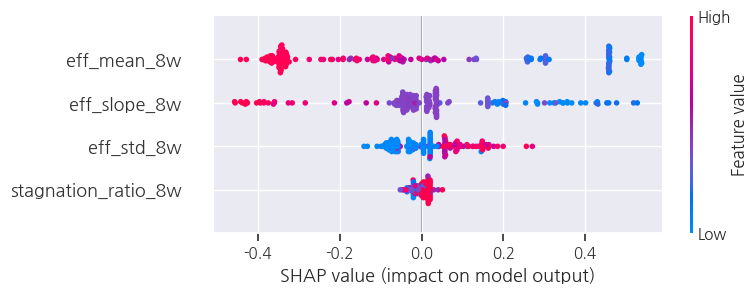

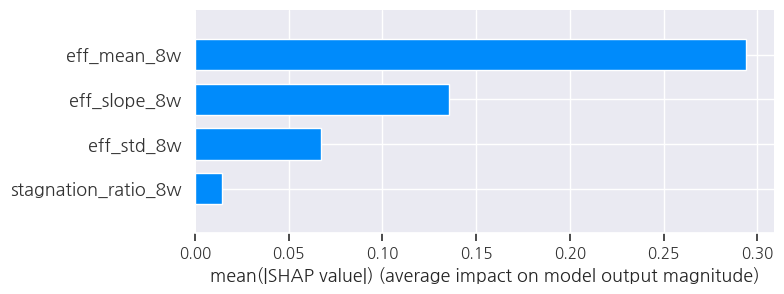

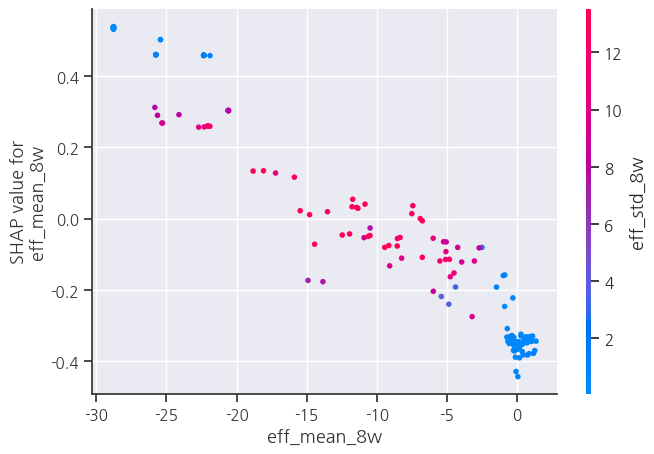

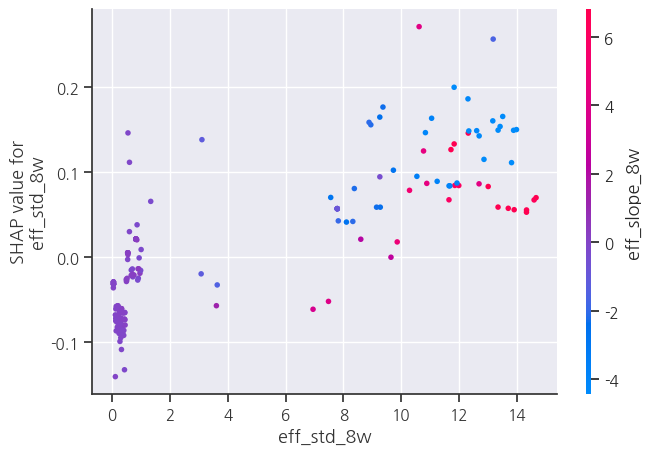

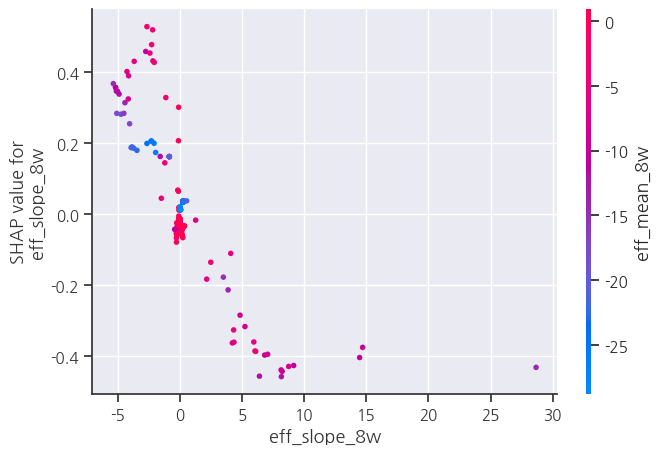

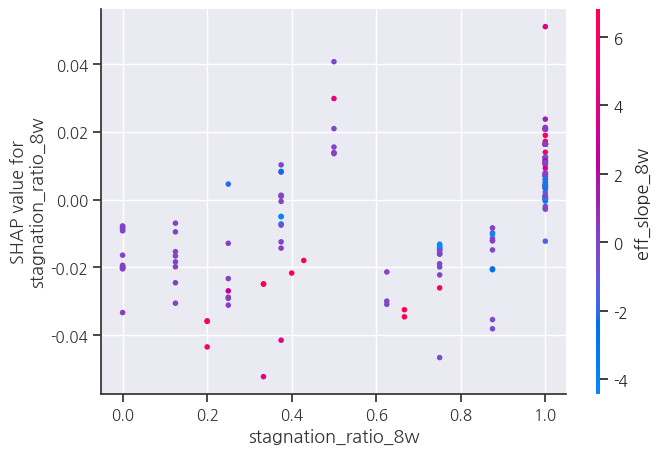

In [ ]:
# =========================================
# 4. XGBoost SHAP 분석
# =========================================

# 1) 예측 함수 포장 (SHAP은 callable을 좋아함)
f_pred = lambda data: xgb.predict_proba(data)[:, 1]

# 2) 배경 데이터 (속도 때문에 일부 샘플만 사용해도 됨)
background = X_train.sample(min(200, len(X_train)), random_state=42)

# 3) Explainer 생성
explainer = shap.Explainer(f_pred, background)

# 4) Test 셋에 대한 SHAP 값 계산
shap_values = explainer(X_test)   # shap_values.shape == (n_test, n_features)

print("shap_values shape:", shap_values.values.shape)

# 5) Summary plot (점 그래프)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

# 6) Bar plot (평균 절대값 기준 중요도)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_type="bar")

# 7) 피처별 의존도 플롯 (원하면)
for f in feature_cols:
    shap.dependence_plot(f, shap_values.values, X_test, feature_names=feature_cols)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ─────────────────────────
# 1. 계수 / 오즈비 데이터프레임 만들기
# ─────────────────────────
coef = logit.coef_[0]   # (n_features,) 벡터

coef_df = pd.DataFrame({
    "feature": feature_cols,   # 사용한 피처 이름 리스트
    "coef": coef
})
coef_df["odds_ratio"] = np.exp(coef_df["coef"])

# 보기 좋게 정렬 (영향력 큰 순서)
coef_df = coef_df.sort_values("odds_ratio", ascending=True).reset_index(drop=True)

print(coef_df)


               feature      coef  odds_ratio
0         eff_slope_8w -2.266611    0.103663
1          eff_mean_8w -1.744795    0.174681
2  stagnation_ratio_8w  0.613454    1.846800
3           eff_std_8w  1.129196    3.093168


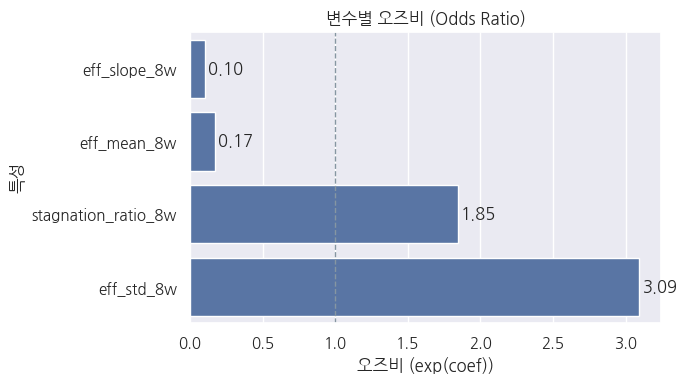

In [ ]:
plt.figure(figsize=(7,4))

sns.barplot(
    data=coef_df,
    x="odds_ratio",
    y="feature",
    orient="h"
)

plt.axvline(1.0, color="#8696a2", linestyle="--", linewidth=1)  # OR=1 기준선

plt.title("변수별 오즈비 (Odds Ratio)")
plt.xlabel("오즈비 (exp(coef))")
plt.ylabel("특성")

# 막대 끝에 수치 라벨 달기
for i, row in coef_df.iterrows():
    x = row["odds_ratio"]
    y = i
    plt.text(
        x + 0.02, y,
        f"{x:.2f}",
        va="center"
    )

plt.tight_layout()
plt.show()


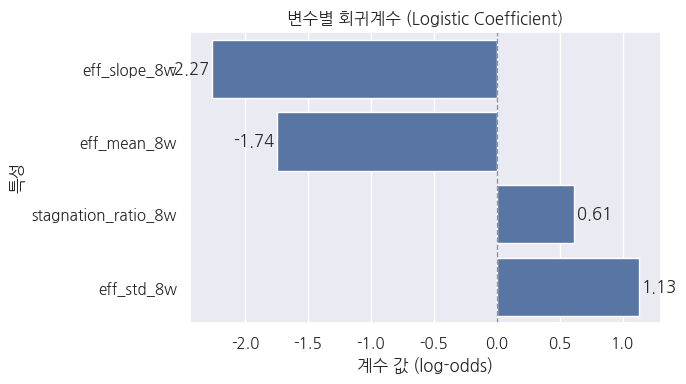

In [ ]:
plt.figure(figsize=(7,4))

sns.barplot(
    data=coef_df,
    x="coef",
    y="feature",
    orient="h"
)

plt.axvline(0.0, color="#8696a2", linestyle="--", linewidth=1)  # coef=0 기준선

plt.title("변수별 회귀계수 (Logistic Coefficient)")
plt.xlabel("계수 값 (log-odds)")
plt.ylabel("특성")

for i, row in coef_df.iterrows():
    x = row["coef"]
    y = i
    plt.text(
        x + (0.02 if x >= 0 else -0.02),
        y,
        f"{x:.2f}",
        va="center",
        ha="left" if x >= 0 else "right"
    )

plt.tight_layout()
plt.show()


#가설2. 스펙기반 성장효율X이탈

##스펙X이탈 연관성 확인

In [ ]:
# =========================================
# 0. Colab 환경 세팅 + 한글 폰트 설치
# =========================================
!apt-get update -qq
!apt-get install -qq fonts-nanum
!pip install koreanize_matplotlib

import koreanize_matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 폰트 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
plt.rcParams["font.family"] = "NanumGothic"
plt.rcParams["axes.unicode_minus"] = False

# seaborn 스타일
sns.set(font="NanumGothic", rc={"axes.unicode_minus": False})

print(">>> NanumGothic 폰트 적용 완료!")

# =========================================
# 1. 데이터 로딩 & 기본 전처리
# =========================================
df = pd.read_csv("growth_log_v2_f_v2.csv", parse_dates=["date"])

# 스펙 컬럼 포함하여 필요한 것만 유지
spec_cols = [
    "전투력",
    "보스_데미지",
    "방어율_무시",
    "크리티컬_데미지",
    "아케인포스",
    "어센틱포스",
    "스타포스"
]

df = df[["ocid", "date", "character_level", "character_exp", "access_flag"] + spec_cols].dropna()

df["character_level"] = pd.to_numeric(df["character_level"], errors="coerce")
df["character_exp"]   = pd.to_numeric(df["character_exp"], errors="coerce")
df = df.dropna()

df = df.sort_values(["ocid","date"])


# =========================================
# 2. access_flag → active(0/1)
# =========================================
def to_bool(x):
    if pd.isna(x): return False
    if isinstance(x,str):
        s=x.strip().lower()
        if s in ["true","1","y","yes","t"]: return True
        if s in ["false","0","n","no","f"]: return False
    try: return bool(int(x))
    except: return False

df["active"] = df["access_flag"].apply(to_bool).astype(int)


# =========================================
# 3. EXP 기반 성장 변수 (eff 포함)
# =========================================
df["exp_diff"] = df.groupby("ocid")["character_exp"].diff().fillna(0)
df.loc[df["exp_diff"] < 0, "exp_diff"] = 0

df["growth_4w"] = (
    df.groupby("ocid")["exp_diff"]
      .rolling(window=4, min_periods=1).mean()
      .reset_index(level=0, drop=True)
)

# 레벨 그룹
bins=[260,265,270,275,10**6]
labels=["260-264","265-269","270-274","275+"]
df["level_group"] = pd.cut(df["character_level"], bins=bins, labels=labels, right=False)

# 로그정규화 효율
avg = (
    df.groupby(["date","level_group"], observed=True)["growth_4w"]
      .mean()
      .rename("avg_growth")
)
df = df.merge(avg, on=["date","level_group"], how="left")

df["eff"] = np.log1p(df["growth_4w"]) - np.log1p(df["avg_growth"].clip(lower=1e-6))


# =========================================
# 4. 패널 생성 & 영구 이탈 라벨링
# =========================================
df["week"] = df["date"].dt.isocalendar().week.astype(int)

panel = (
    df[["ocid","week","date","active","eff", "level_group"] + spec_cols]
      .dropna(subset=["level_group"])
      .drop_duplicates(["ocid","week"])
      .sort_values(["ocid","week"])
)

def persistent_from_week(s_active):
    a = s_active.to_numpy().astype(int)
    n = len(a)
    out = np.zeros(n, dtype=int)
    still0=True
    for i in range(n-1, -1, -1):
        if a[i] == 1:
            still0 = False
        if a[i] == 0 and still0:
            out[i] = 1
    return pd.Series(out, index=s_active.index)

panel["churn_future"] = (
    panel.groupby("ocid")["active"]
          .apply(persistent_from_week)
          .reset_index(level=0, drop=True)
)

# 유저별 최종 라벨
churn_flag = panel.groupby("ocid")["churn_future"].max().astype(int)


# =========================================
# 5. 최근 8주 기반 스냅샷 생성
# =========================================
snapshot_date = df['date'].max()
start_date = snapshot_date - pd.Timedelta(weeks=7)

df_win = df[(df['date'] >= start_date) & (df['date'] <= snapshot_date)].copy()
df_win['weeks_from_start'] = ((df_win['date'] - start_date).dt.days // 7).astype(int)


# 최신 스펙 1개만 가져오기
latest_spec = (
    df.sort_values(["ocid","date"])
      .groupby("ocid")
      .tail(1)
      .set_index("ocid")[spec_cols]
)

# 최종 8주 스냅샷 DF
df_snap = pd.DataFrame(index=latest_spec.index)
df_snap = df_snap.join(latest_spec)
df_snap["label"] = churn_flag
df_snap = df_snap.reset_index()

print(df_snap.head())


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
>>> NanumGothic 폰트 적용 완료!
                               ocid         전투력  보스_데미지  방어율_무시  크리티컬_데미지  \
0  001d0f7171bf3a62f5b2f04c1e7a93cb  37733528.0   365.0   95.03      46.0   
1  001e51e7b5575d34bf33ef98d9799f16  14149700.0   203.0   93.25      59.0   
2  004a8e007b27ad1fa1dc7e836991ec15  50953391.0   309.0   93.23      61.0   
3  00a87a8b17854233aac80ea802be42bb  96286743.0   411.0   92.49     111.7   
4  01169d5649332f7ace03f240ec394c4d  80421372.0   403.0   94.21     102.1   

    아케인포스  어센틱포스   스타포스  label  
0  1350.0  230.0  249.0    1.0  
1  1090.0  270.0  244.0    1.0  
2  1450.0  280.0  225.0    0.0  
3  1450.0  330.0  311.0    0.0  
4  1360.0  250.0  314.0    0.0  


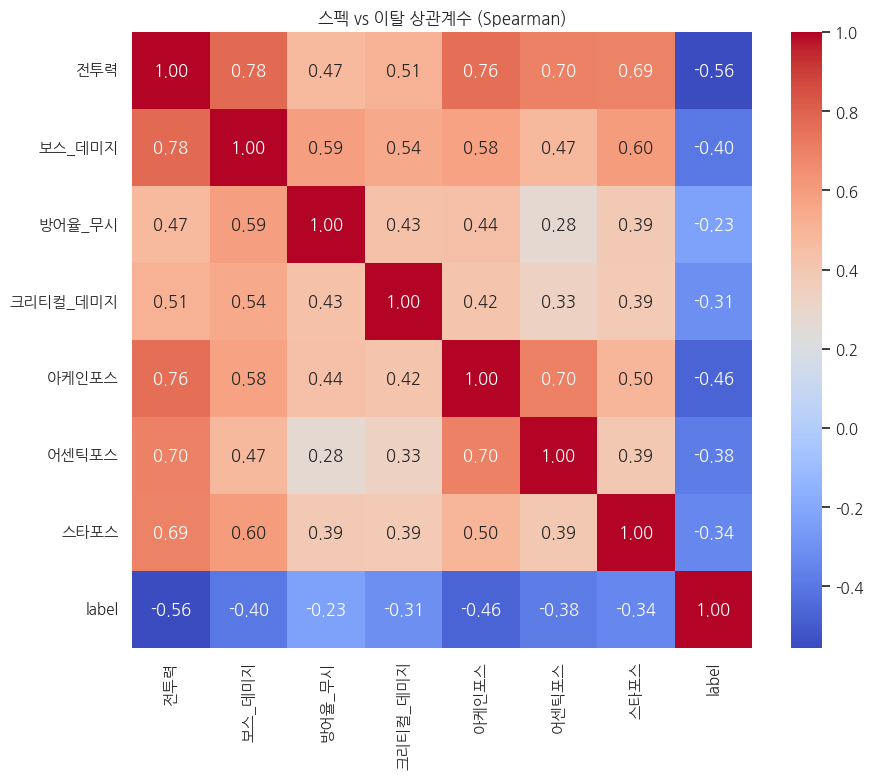

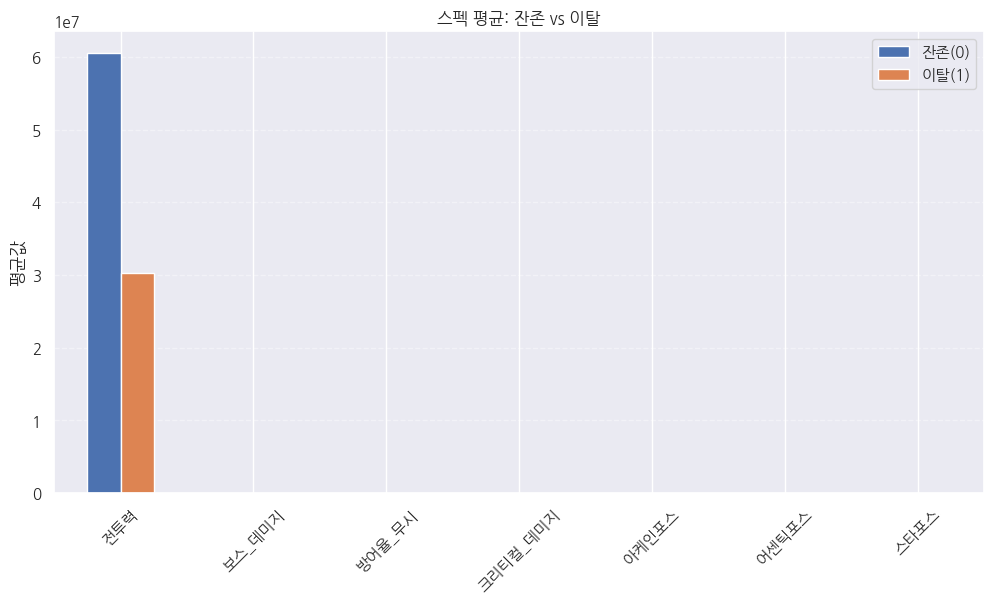

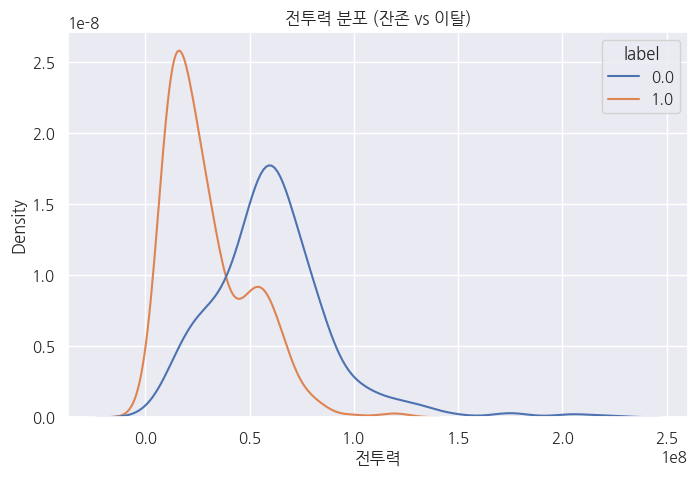

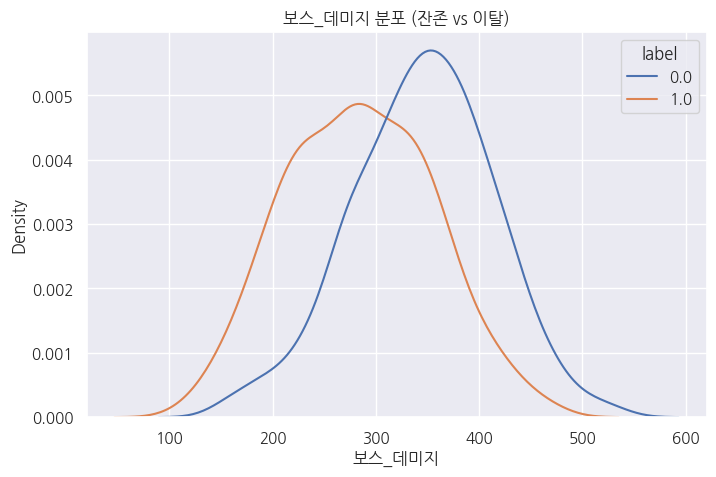

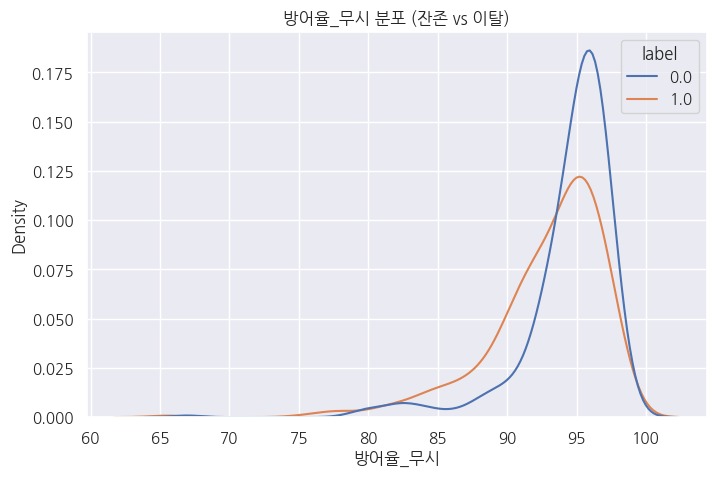

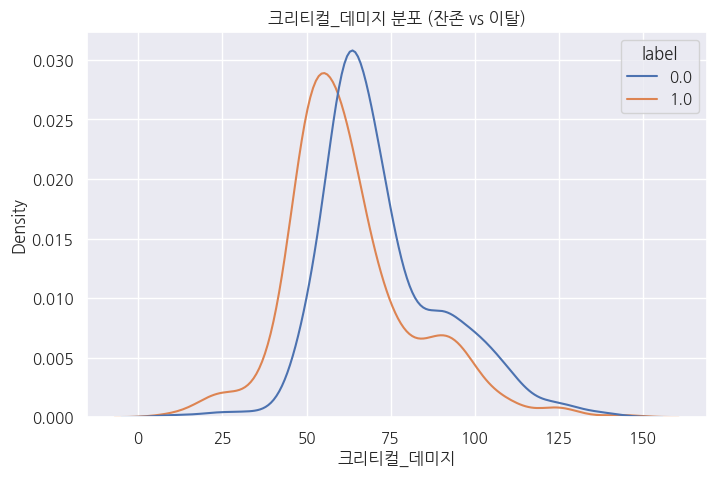

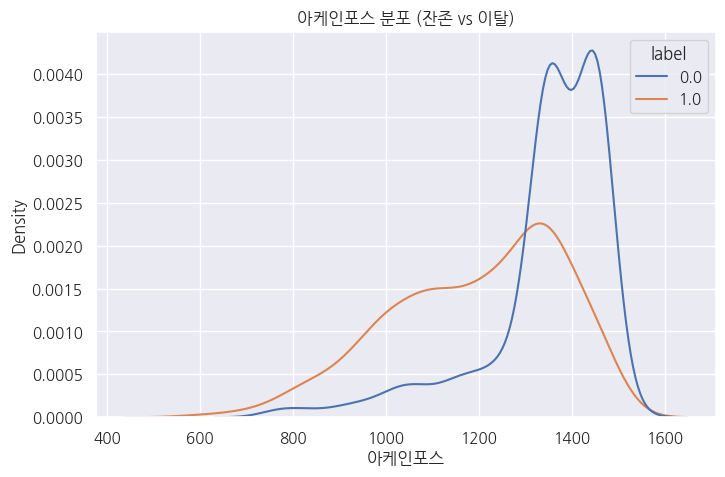

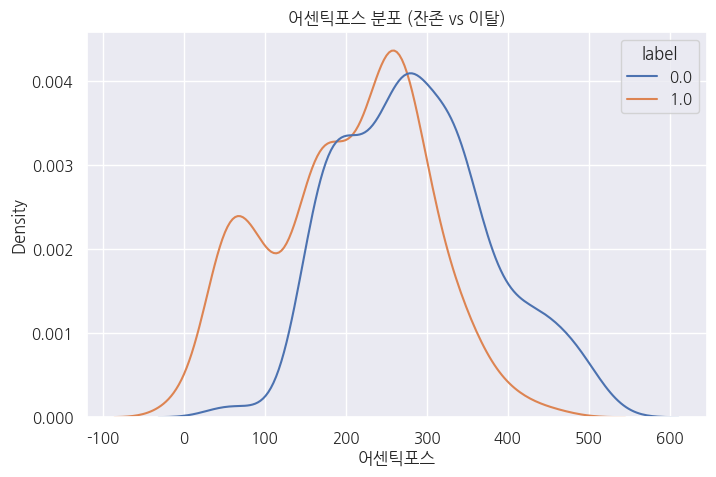

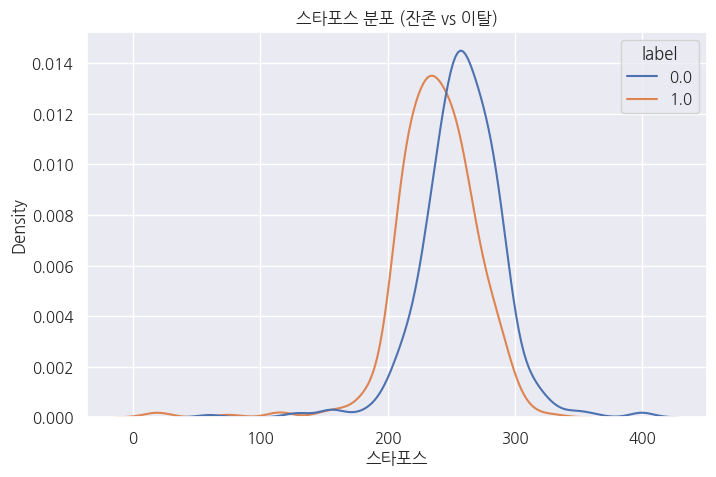

In [ ]:
# =========================================
# 6. 스펙 vs 이탈 상관계수 (Spearman)
# =========================================
corr = df_snap[spec_cols + ["label"]].corr(method="spearman")

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("스펙 vs 이탈 상관계수 (Spearman)")
plt.show()


# =========================================
# 7. 이탈자 vs 잔존자 평균 비교
# =========================================
mean_df = df_snap.groupby("label")[spec_cols].mean().T
mean_df.columns = ["잔존(0)", "이탈(1)"]

mean_df.plot(kind="bar", figsize=(12,6))
plt.title("스펙 평균: 잔존 vs 이탈")
plt.ylabel("평균값")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.show()


# =========================================
# 8. 각 스펙 분포 (KDE)
# =========================================
for col in spec_cols:
    plt.figure(figsize=(8,5))
    sns.kdeplot(data=df_snap, x=col, hue="label", common_norm=False)
    plt.title(f"{col} 분포 (잔존 vs 이탈)")
    plt.show()


##전처리

- 스펙 성장 효율 계산
- 전투력_eff 기반 mean/std/slope/stagnation 계산

In [ ]:
# ---------------------------------
# 준비: 사용할 스펙 리스트
# ---------------------------------
spec_core = ["전투력", "보스_데미지", "아케인포스", "어센틱포스", "스타포스"]

# ---------------------------------
# 스펙별 주간 증가량 + 4주 롤링 평균
# ---------------------------------
for col in spec_core:
    diff_col = f"{col}_diff"
    g4w_col  = f"{col}_g4w"

    # 주간 증가량
    df[diff_col] = df.groupby("ocid")[col].diff().fillna(0)
    df.loc[df[diff_col] < 0, diff_col] = 0  # 감소는 0으로 처리

    # 4주 평균 성장량
    df[g4w_col] = (
        df.groupby("ocid")[diff_col]
          .rolling(window=4, min_periods=1).mean()
          .reset_index(level=0, drop=True)
    )


In [ ]:
# ---------------------------------
# 또래(같은 날짜 & 레벨구간) 대비 “스펙 효율” 계산
# ---------------------------------
import numpy as np

for col in spec_core:
    g4w_col   = f"{col}_g4w"
    avg_col   = f"{col}_avg_g4w"
    eff_col   = f"{col}_eff"

    avg_g = (
        df.groupby(["date","level_group"], observed=True)[g4w_col]
          .mean()
          .rename(avg_col)
    )

    df = df.merge(avg_g, on=["date","level_group"], how="left")

    df[eff_col] = (
        np.log1p(df[g4w_col])
        - np.log1p(df[avg_col].clip(lower=1e-6))
    )

In [ ]:
# ---------------------------------
# 최근 8주 기준 유저별 스펙 효율 평균 (by spec)
# ---------------------------------

# 최근 8주 윈도우는 앞에서 쓴 것 재사용
snapshot_date = df['date'].max()
start_date = snapshot_date - pd.Timedelta(weeks=7)

df_win = df[(df['date'] >= start_date) & (df['date'] <= snapshot_date)].copy()
df_win['weeks_from_start'] = ((df_win['date'] - start_date).dt.days // 7).astype(int)

eff_cols = [f"{c}_eff" for c in spec_core]

def agg_spec_eff(g):
    out = {}
    for col in eff_cols:
        vals = g[col].dropna().values
        if len(vals) == 0:
            out[f"{col}_mean_8w"] = np.nan
        else:
            out[f"{col}_mean_8w"] = vals.mean()
    return pd.Series(out)

# ✅ group_keys=False + reset_index()
df_spec_snap = (
    df_win.groupby("ocid", group_keys=False)
          .apply(agg_spec_eff)
          .reset_index()
)

# ✅ ocid 컬럼 기준으로 라벨 매핑
df_spec_snap["label"] = (
    df_spec_snap["ocid"]
      .map(churn_flag)
      .fillna(0)
      .astype(int)
)

df_spec_snap.head()



/tmp/ipython-input-1760087559.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_spec_eff)


,ocid,전투력_eff_mean_8w,보스_데미지_eff_mean_8w,아케인포스_eff_mean_8w,어센틱포스_eff_mean_8w,스타포스_eff_mean_8w,label
0,001d0f7171bf3a62f5b2f04c1e7a93cb,-5.873867,-0.465535,-0.834803,-0.795947,-0.670917,1
1,001e51e7b5575d34bf33ef98d9799f16,-11.964791,-1.053782,-1.344946,-0.792560,-0.291552,1
2,004a8e007b27ad1fa1dc7e836991ec15,-0.305544,-0.280359,-0.820499,-0.337588,-1.682886,0
3,00a87a8b17854233aac80ea802be42bb,0.589814,0.709770,-1.231225,0.356656,0.030885,0
4,01169d5649332f7ace03f240ec394c4d,0.670269,-0.208734,0.979382,-0.376966,0.586012,0


In [ ]:
# ---------------------------------
# 로지스틱 회귀로 “가중치” 추정 → 통합 스펙 효율 만들기
# ---------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 모델에 넣을 피처 리스트
eff_mean_cols = [f"{c}_eff_mean_8w" for c in spec_core]

# 결측 제거
model_df = df_spec_snap.dropna(subset=eff_mean_cols + ["label"]).copy()

X = model_df[eff_mean_cols].values
y = model_df["label"].values  # 1 = 이탈, 0 = 잔존

# 스케일링
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 로지스틱 회귀 (L2, 기본)
logit = LogisticRegression(max_iter=1000)
logit.fit(X_std, y)

# 계수 확인
coef = pd.Series(logit.coef_[0], index=eff_mean_cols).sort_values()
print("로지스틱 회귀 계수(표준화 기준):")
print(coef)

# 계수 기반 가중치 만들기
# label=1이 이탈이라, 효율이 높을수록 이탈이 감소 → 보통 계수는 음수일 것
# 그래서 부호를 반대로 뒤집고, 절대값 기준으로 합이 1이 되도록 정규화
w = -coef         # 부호 반전
w = w / w.abs().sum()

print("\n정규화된 가중치:")
print(w)

# 통합 스펙 효율 계산
model_df["spec_eff_mean_8w"] = (X_std @ w.values)

model_df[["ocid", "spec_eff_mean_8w", "label"] + eff_mean_cols].head()


로지스틱 회귀 계수(표준화 기준):
전투력_eff_mean_8w      -2.030983
어센틱포스_eff_mean_8w    -0.097548
아케인포스_eff_mean_8w    -0.076294
보스_데미지_eff_mean_8w    0.155691
스타포스_eff_mean_8w      0.211139
dtype: float64

정규화된 가중치:
전투력_eff_mean_8w       0.789757
어센틱포스_eff_mean_8w     0.037932
아케인포스_eff_mean_8w     0.029667
보스_데미지_eff_mean_8w   -0.060541
스타포스_eff_mean_8w     -0.082102
dtype: float64


,ocid,spec_eff_mean_8w,label,전투력_eff_mean_8w,보스_데미지_eff_mean_8w,아케인포스_eff_mean_8w,어센틱포스_eff_mean_8w,스타포스_eff_mean_8w
0,001d0f7171bf3a62f5b2f04c1e7a93cb,-0.065434,1,-5.873867,-0.465535,-0.834803,-0.795947,-0.670917
1,001e51e7b5575d34bf33ef98d9799f16,-1.033616,1,-11.964791,-1.053782,-1.344946,-0.792560,-0.291552
2,004a8e007b27ad1fa1dc7e836991ec15,0.828572,0,-0.305544,-0.280359,-0.820499,-0.337588,-1.682886
3,00a87a8b17854233aac80ea802be42bb,0.755361,0,0.589814,0.709770,-1.231225,0.356656,0.030885
4,01169d5649332f7ace03f240ec394c4d,0.800574,0,0.670269,-0.208734,0.979382,-0.376966,0.586012


In [ ]:
# =========================================
# 0. 최근 8주 데이터 준비
# =========================================

snapshot_date = df['date'].max()
start_date = snapshot_date - pd.Timedelta(weeks=7)

df_win = df[(df['date'] >= start_date) & (df['date'] <= snapshot_date)].copy()
df_win['weeks_from_start'] = ((df_win['date'] - start_date).dt.days // 7).astype(int)

# =========================================
# 1. 전투력_eff 기반 mean/std/slope/stagnation 계산 함수
# =========================================

def agg_power_eff(g):
    # dropna 마스크 (eff와 x 길이를 동일하게)
    mask = g["전투력_eff"].notna()

    eff = g.loc[mask, "전투력_eff"].values
    x   = g.loc[mask, "weeks_from_start"].values.astype(float)

    # 아무 데이터 없으면 NaN 세트 리턴
    if len(eff) == 0:
        return pd.Series({
            "power_eff_mean_8w": np.nan,
            "power_eff_std_8w": np.nan,
            "power_eff_slope_8w": np.nan,
            "power_eff_stagnation_ratio_8w": np.nan
        })

    # slope 계산
    if len(eff) > 1 and np.ptp(x) > 0:
        x_center = x - x.mean()
        slope = np.polyfit(x_center, eff, 1)[0]
    else:
        slope = 0.0

    # 결과 패키징
    return pd.Series({
        "power_eff_mean_8w": eff.mean(),
        "power_eff_std_8w": eff.std(ddof=0),
        "power_eff_slope_8w": slope,
        "power_eff_stagnation_ratio_8w": np.mean(eff < 0)
    })

# =========================================
# 2. 유저별 스냅샷 생성
# =========================================

df_power_snap = (
    df_win.groupby("ocid", group_keys=False)
          .apply(agg_power_eff)
          .reset_index()
)

# =========================================
# 3. 이탈 라벨 붙이기
# =========================================

df_power_snap["label"] = (
    df_power_snap["ocid"]
        .map(churn_flag)
        .fillna(0)
        .astype(int)
)

df_power_snap.head()


/tmp/ipython-input-2394823184.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_power_eff)


,ocid,power_eff_mean_8w,power_eff_std_8w,power_eff_slope_8w,power_eff_stagnation_ratio_8w,label
0,001d0f7171bf3a62f5b2f04c1e7a93cb,-5.873867,7.017397,-0.808846,1.00,1
1,001e51e7b5575d34bf33ef98d9799f16,-11.964791,0.537398,0.221118,1.00,1
2,004a8e007b27ad1fa1dc7e836991ec15,-0.305544,0.701513,-0.189004,0.50,0
3,00a87a8b17854233aac80ea802be42bb,0.589814,0.629669,0.250996,0.25,0
4,01169d5649332f7ace03f240ec394c4d,0.670269,0.879376,-0.194508,0.25,0


##EDA

       power_eff_mean_log  power_eff_std_log  power_eff_slope_8w  \
count        9.030000e+02       9.030000e+02          903.000000   
mean         2.146413e+00       9.135615e-01            0.137283   
std          8.113100e-01       7.152857e-01            1.951166   
min          9.999995e-07       9.999995e-07           -2.871135   
25%          1.791291e+00       3.716905e-01           -0.249583   
50%          2.529135e+00       5.172662e-01           -0.005072   
75%          2.758460e+00       1.768795e+00            0.174394   
max          2.909457e+00       2.264975e+00           17.261773   

       power_eff_stagnation_ratio_8w  
count                     903.000000  
mean                        0.722589  
std                         0.331734  
min                         0.000000  
25%                         0.500000  
50%                         0.875000  
75%                         1.000000  
max                         1.000000  

label 분포:
label
0    0.534141
1    

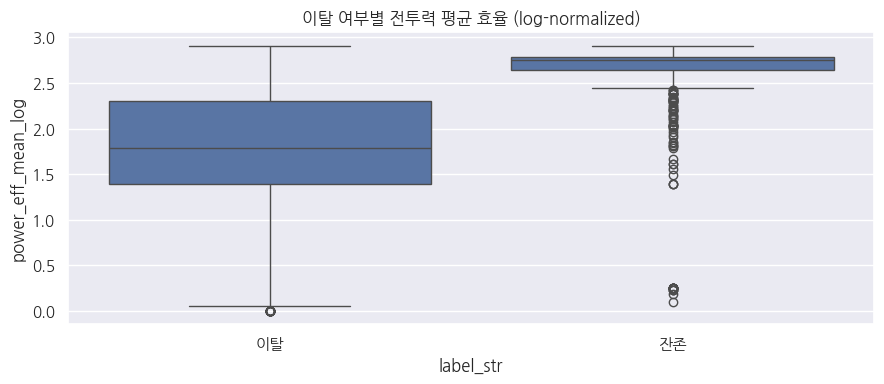

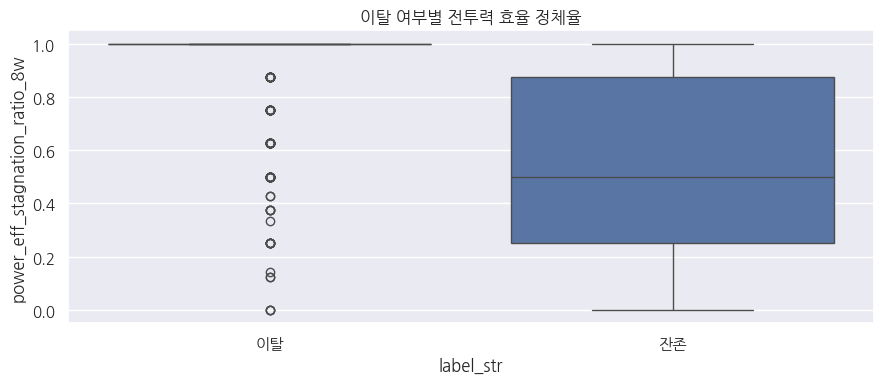

/tmp/ipython-input-2166097.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_power_eda.groupby("stagn_bin")["label"]


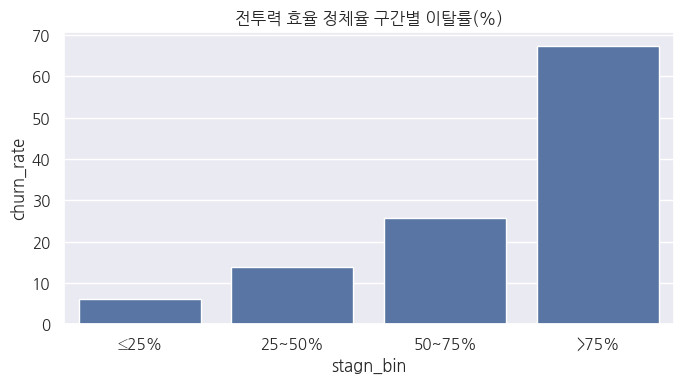

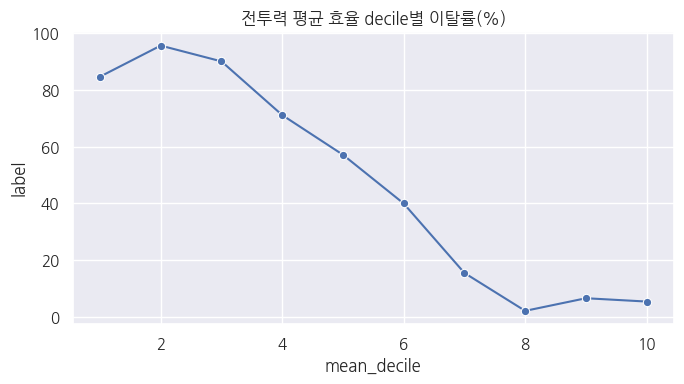

/tmp/ipython-input-2166097.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_power_eda.groupby("level_group")["label"]


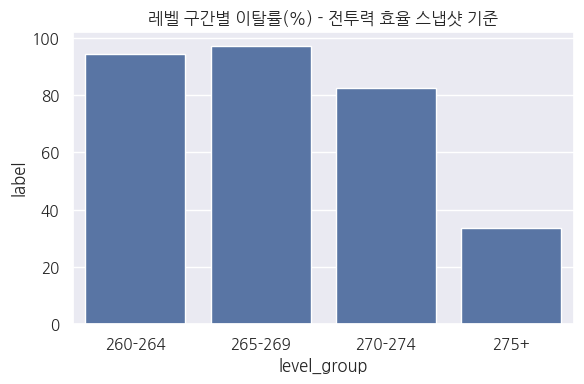

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# =========================================
# 0. EDA용 복사본 + 레벨그룹 붙이기
# =========================================

df_power_eda = df_power_snap.copy()

# 마지막 레벨 그룹 가져와서 붙이기 (EXP 때 했던 로직 재활용)
last_lg = (
    df.sort_values(["ocid","date"])
      .groupby("ocid")
      .tail(1)
      .set_index("ocid")["level_group"]
)

df_power_eda["level_group"] = df_power_eda["ocid"].map(last_lg)

# label 텍스트 컬럼
df_power_eda["label_str"] = df_power_eda["label"].map({0: "잔존", 1: "이탈"})

# =========================================
# 1. winsorizing (상/하위 0.1% 절단)
# =========================================
clip_cols = ["power_eff_mean_8w", "power_eff_std_8w", "power_eff_slope_8w"]

for c in clip_cols:
    q_low  = df_power_eda[c].quantile(0.001)
    q_high = df_power_eda[c].quantile(0.999)
    df_power_eda[c] = df_power_eda[c].clip(q_low, q_high)

# =========================================
# 2. log-transform (mean/std만)
# =========================================
df_power_eda["power_eff_mean_log"] = np.log1p(df_power_eda["power_eff_mean_8w"] - df_power_eda["power_eff_mean_8w"].min() + 1e-6)
df_power_eda["power_eff_std_log"]  = np.log1p(df_power_eda["power_eff_std_8w"]  - df_power_eda["power_eff_std_8w"].min()  + 1e-6)
# slope는 양/음 모두 가능 → log 변환 X

# =========================================
# 3. 기본 통계
# =========================================
print(
    df_power_eda.describe()[
        ["power_eff_mean_log", "power_eff_std_log", "power_eff_slope_8w", "power_eff_stagnation_ratio_8w"]
    ]
)
print("\nlabel 분포:")
print(df_power_eda["label"].value_counts(normalize=True))

# =========================================
# 4. 평균 스펙 효율 / 정체율 박스플롯
# =========================================
plt.figure(figsize=(9,4))
sns.boxplot(data=df_power_eda, x="label_str", y="power_eff_mean_log")
plt.title("이탈 여부별 전투력 평균 효율 (log-normalized)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
sns.boxplot(data=df_power_eda, x="label_str", y="power_eff_stagnation_ratio_8w")
plt.title("이탈 여부별 전투력 효율 정체율")
plt.tight_layout()
plt.show()

# =========================================
# 5. 정체율 구간별 이탈률
# =========================================
bins_st = [0, 0.25, 0.5, 0.75, 1.01]
labels_st = ["≤25%","25~50%","50~75%",">75%"]

df_power_eda["stagn_bin"] = pd.cut(
    df_power_eda["power_eff_stagnation_ratio_8w"],
    bins=bins_st, labels=labels_st, right=False
)

st_rate = (
    df_power_eda.groupby("stagn_bin")["label"]
      .mean()
      .mul(100)
      .reset_index(name="churn_rate")
)

plt.figure(figsize=(7,4))
sns.barplot(data=st_rate, x="stagn_bin", y="churn_rate")
plt.title("전투력 효율 정체율 구간별 이탈률(%)")
plt.tight_layout()
plt.show()

# =========================================
# 6. 전투력 평균 효율 decile별 이탈률
# =========================================
df_power_eda["mean_decile"] = pd.qcut(
    df_power_eda["power_eff_mean_log"].rank(method="first"),
    10, labels=False
)

mean_curve = (
    df_power_eda.groupby("mean_decile")["label"]
      .mean()
      .mul(100)
      .reset_index()
)
mean_curve["mean_decile"] = mean_curve["mean_decile"] + 1

plt.figure(figsize=(7,4))
sns.lineplot(data=mean_curve, x="mean_decile", y="label", marker="o")
plt.title("전투력 평균 효율 decile별 이탈률(%)")
plt.tight_layout()
plt.show()

# =========================================
# 7. 레벨 그룹별 이탈률 (전투력 효율 기준)
# =========================================
plt.figure(figsize=(6,4))
sns.barplot(
    data=(
        df_power_eda.groupby("level_group")["label"]
          .mean()
          .mul(100)
          .reset_index()
    ),
    x="level_group", y="label"
)
plt.title("레벨 구간별 이탈률(%) - 전투력 효율 스냅샷 기준")
plt.tight_layout()
plt.show()

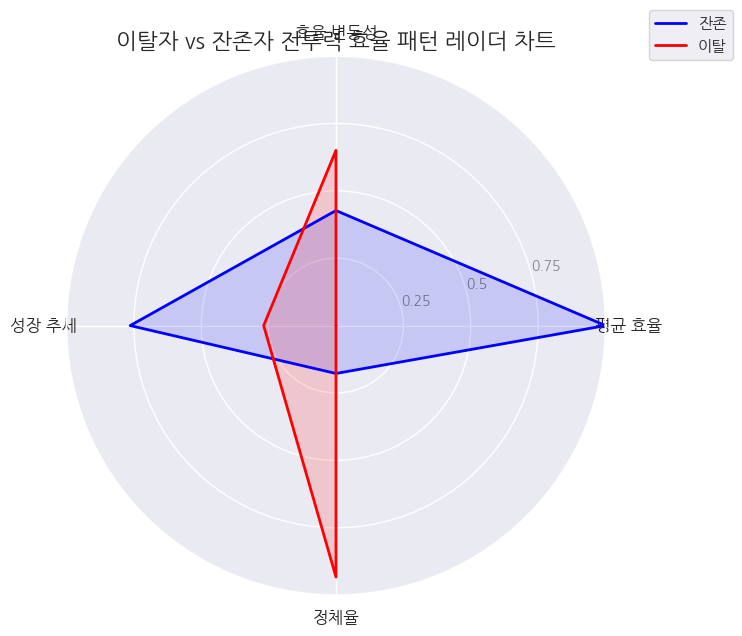

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# 0) 원 데이터에서 복사
df_power_plot = df_power_snap.copy()

# 1) 사용할 지표 (전투력 효율 4종)
cols = [
    "power_eff_mean_8w",
    "power_eff_std_8w",
    "power_eff_slope_8w",
    "power_eff_stagnation_ratio_8w",
]
nice_labels = ["평균 효율", "효율 변동성", "성장 추세", "정체율"]

# 2) label_str 생성
df_power_plot["label_str"] = df_power_plot["label"].map({0: "잔존", 1: "이탈"})

# 필요 컬럼 결측 제거 (없으면 레이더 평균이 NaN됨)
df_power_plot = df_power_plot.dropna(subset=cols)

# 3) 전체 분포 기준으로 z-score 표준화
for c in cols:
    mu = df_power_plot[c].mean()
    sigma = df_power_plot[c].std(ddof=0)
    df_power_plot[c + "_z"] = (df_power_plot[c] - mu) / (sigma + 1e-9)

z_cols = [c + "_z" for c in cols]

# 4) 잔존/이탈별 z-score 평균
agg_z = df_power_plot.groupby("label_str")[z_cols].mean()

# 5) 레이더용 0~1 스케일로 재변환 (음수 방지용 shift)
z_min = agg_z.min().min()
z_max = agg_z.max().max()
agg_norm = (agg_z - z_min) / (z_max - z_min + 1e-9)

# 6) 레이더 차트 그리기
N = len(cols)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

for group, color in zip(["잔존", "이탈"], ["blue", "red"]):
    values = agg_norm.loc[group].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=group, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

# 축/레이블
plt.xticks(angles[:-1], nice_labels, fontsize=12)
ax.set_rlabel_position(15)
plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
plt.ylim(0, 1)

plt.title("이탈자 vs 잔존자 전투력 효율 패턴 레이더 차트", fontsize=16)
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))
plt.show()


##모델링

In [ ]:
# 0. 공통 세팅 + 데이터셋 구성

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# -----------------------
# 1) 사용할 피처 정의
# -----------------------
spec_features = [
    "power_eff_mean_8w",
    "power_eff_std_8w",
    "power_eff_slope_8w",
    "power_eff_stagnation_ratio_8w",
]

df_spec_model = df_power_snap.dropna(subset=spec_features + ["label"]).copy()

X = df_spec_model[spec_features].values
y = df_spec_model["label"].values  # 1=이탈, 0=잔존

# -----------------------
# 2) train / test split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("train size:", X_train.shape, "test size:", X_test.shape)


train size: (632, 4) test size: (271, 4)


In [ ]:
# 1. SPEC-only EWS — Logistic Regression (baseline)

# 스케일링
scaler_spec = StandardScaler()
X_train_std = scaler_spec.fit_transform(X_train)
X_test_std  = scaler_spec.transform(X_test)

# 로지스틱 회귀
logit_spec = LogisticRegression(max_iter=1000)
logit_spec.fit(X_train_std, y_train)

proba_spec = logit_spec.predict_proba(X_test_std)[:, 1]
auc_spec   = roc_auc_score(y_test, proba_spec)

print(f"[SPEC-only Logistic] Test AUC: {auc_spec:.4f}")
print()
print(classification_report(y_test, (proba_spec>0.5).astype(int)))


[SPEC-only Logistic] Test AUC: 0.9567

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       144
           1       0.92      0.94      0.93       127

    accuracy                           0.93       271
   macro avg       0.93      0.93      0.93       271
weighted avg       0.93      0.93      0.93       271



In [ ]:
# 2. SPEC-only EWS — XGBoost 모델 (SHAP용 메인 모델)

!pip install xgboost shap -q

import xgboost as xgb
import shap

# XGBoost용 DMatrix or 직접 XGBClassifier 사용
xgb_spec = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    tree_method="hist",  # Colab 속도용
)

xgb_spec.fit(X_train, y_train)

proba_spec_xgb = xgb_spec.predict_proba(X_test)[:, 1]
auc_spec_xgb   = roc_auc_score(y_test, proba_spec_xgb)

print(f"[SPEC-only XGBoost] Test AUC: {auc_spec_xgb:.4f}")


[SPEC-only XGBoost] Test AUC: 0.9446


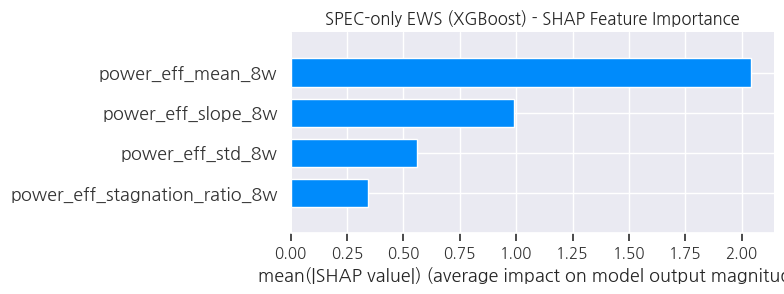

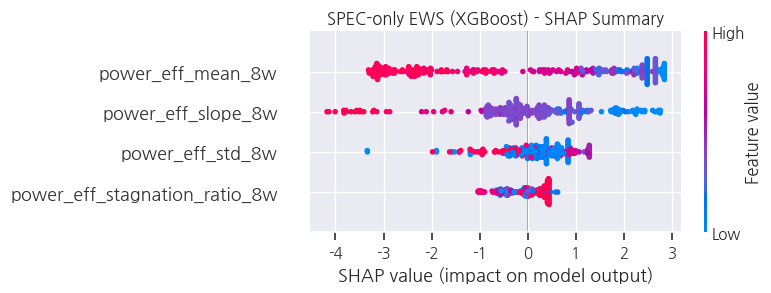

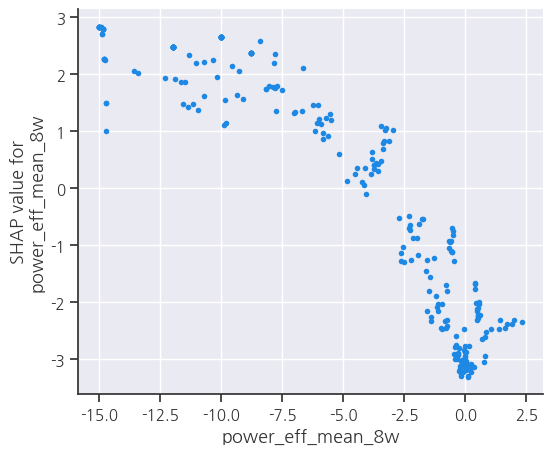

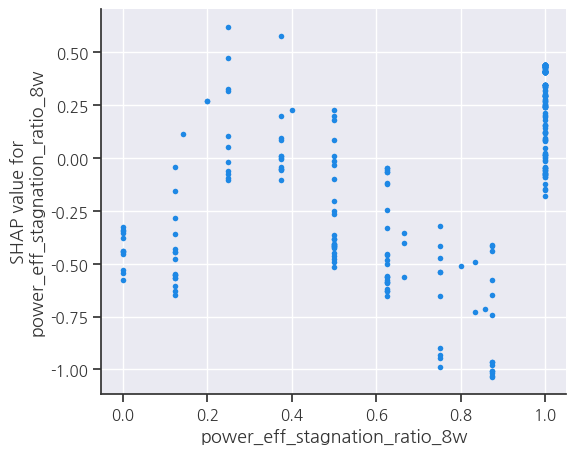

In [ ]:
# 3. SHAP 시각화 (SPEC-only XGBoost)

# SHAP 초기화 (Notebook용)
shap.initjs()

# TreeExplainer로 shap 값 계산
explainer_spec = shap.TreeExplainer(xgb_spec)
shap_values_spec = explainer_spec.shap_values(X_test)

# 피처 이름 붙이기 위해 DataFrame으로 변환
X_test_df = pd.DataFrame(X_test, columns=spec_features)

# 3-1. 전체 feature importance (summary bar)
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values_spec, X_test_df, plot_type="bar", show=False)
plt.title("SPEC-only EWS (XGBoost) - SHAP Feature Importance")
plt.tight_layout()
plt.show()

# 3-2. 분포까지 보는 summary beeswarm
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values_spec, X_test_df, show=False)
plt.title("SPEC-only EWS (XGBoost) - SHAP Summary")
plt.tight_layout()
plt.show()

# 3-3. 개별 피처 dependence plot (예: 평균 효율, 정체율)
# 1) 평균 전투력 효율 vs 이탈 영향
shap.dependence_plot(
    "power_eff_mean_8w", shap_values_spec, X_test_df,
    interaction_index=None
)

# 2) 전투력 효율 정체율 vs 이탈 영향
shap.dependence_plot(
    "power_eff_stagnation_ratio_8w", shap_values_spec, X_test_df,
    interaction_index=None
)


                         feature      coef  odds_ratio
0             power_eff_slope_8w -1.744947    0.174654
1              power_eff_mean_8w -1.702006    0.182317
2  power_eff_stagnation_ratio_8w  0.308936    1.361975
3               power_eff_std_8w  0.602778    1.827188


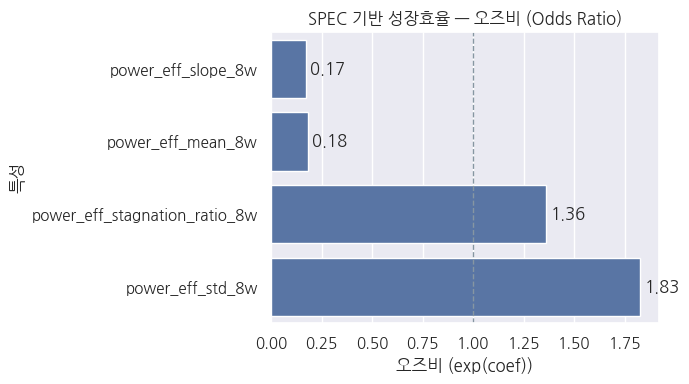

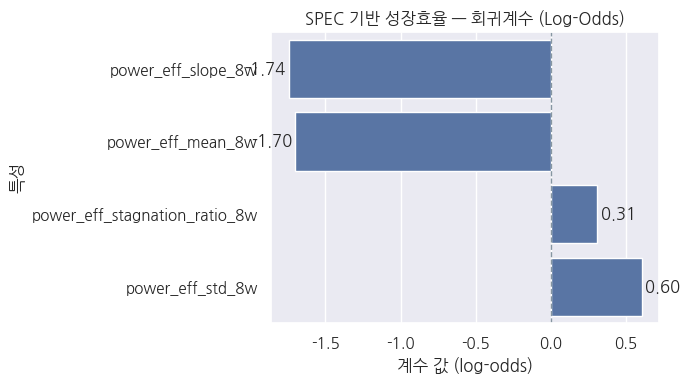

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1) 여기의 logit_spec 은 이미 학습이 끝난 SPEC-only Logistic 모델
#    (네가 위에서 돌린 모델)
# ------------------------------------------------------------

coef = logit_spec.coef_[0]   # (4,) 벡터

# SPEC-only 피처
spec_features = [
    "power_eff_mean_8w",
    "power_eff_std_8w",
    "power_eff_slope_8w",
    "power_eff_stagnation_ratio_8w"
]

coef_df = pd.DataFrame({
    "feature": spec_features,
    "coef": coef
})

coef_df["odds_ratio"] = np.exp(coef_df["coef"])

# 영향력 기준 정렬
coef_df = coef_df.sort_values("odds_ratio", ascending=True).reset_index(drop=True)

print(coef_df)

# ------------------------------------------------------------
# 2) 오즈비 Plot
# ------------------------------------------------------------
plt.figure(figsize=(7,4))
sns.barplot(data=coef_df, x="odds_ratio", y="feature", orient="h")
plt.axvline(1.0, color="#8696a2", linestyle="--", linewidth=1)
plt.title("SPEC 기반 성장효율 — 오즈비 (Odds Ratio)")
plt.xlabel("오즈비 (exp(coef))")
plt.ylabel("특성")

for i, row in coef_df.iterrows():
    plt.text(row["odds_ratio"] + 0.02, i, f"{row['odds_ratio']:.2f}", va="center")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3) Coefficient Plot
# ------------------------------------------------------------
plt.figure(figsize=(7,4))
sns.barplot(data=coef_df, x="coef", y="feature", orient="h")
plt.axvline(0.0, color="#8696a2", linestyle="--", linewidth=1)
plt.title("SPEC 기반 성장효율 — 회귀계수 (Log-Odds)")
plt.xlabel("계수 값 (log-odds)")
plt.ylabel("특성")

for i, row in coef_df.iterrows():
    offset = 0.02 if row["coef"] >= 0 else -0.02
    plt.text(row["coef"] + offset, i, f"{row['coef']:.2f}",
             va="center", ha="left" if row["coef"] >= 0 else "right")

plt.tight_layout()
plt.show()


#HYBRID(EFF_EXP + EFF_SPEC) 모델링

/tmp/ipython-input-710124109.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_exp_snap = df_win_exp.groupby("ocid", group_keys=False).apply(agg_user_exp)


df_exp_snap head:
                               ocid  eff_mean_8w  eff_std_8w  eff_slope_8w  \
0  001d0f7171bf3a62f5b2f04c1e7a93cb    -6.569631    9.209561      1.066104   
1  001e51e7b5575d34bf33ef98d9799f16   -25.757934    0.536066      0.226766   
2  004a8e007b27ad1fa1dc7e836991ec15     0.362381    0.616881      0.234900   
3  00a87a8b17854233aac80ea802be42bb     0.812660    0.185769      0.021693   
4  01169d5649332f7ace03f240ec394c4d    -0.724094    0.800419     -0.105023   

   stagnation_ratio_8w  label level_group  
0                1.000      1        275+  
1                1.000      1     270-274  
2                0.375      0        275+  
3                0.000      0        275+  
4                0.875      0        275+  

샘플 수 확인:
EXP-only 샘플 수 : 901
SPEC-only 샘플 수: 903
HYBRID 샘플 수   : 901

X 모양 확인:
X_exp_train   : (630, 4)
X_spec_train  : (630, 4)
X_hyb_train   : (630, 8)

=== EXP / SPEC / HYBRID AUC 비교 ===
     Setting     Model  Test_AUC
0   EXP-only  Logistic  0

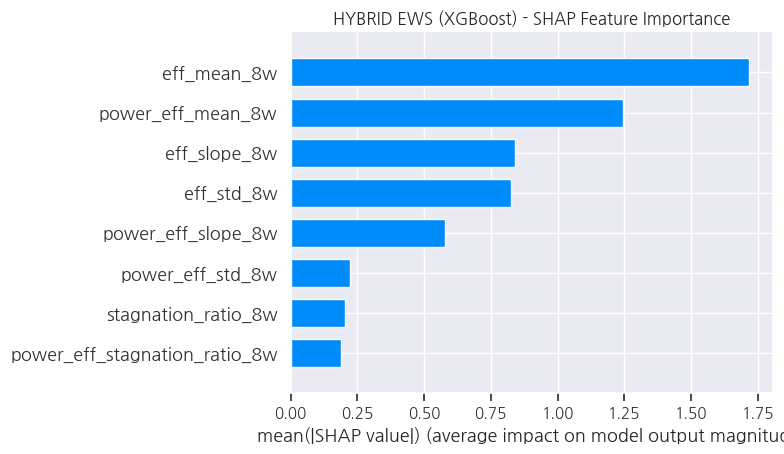

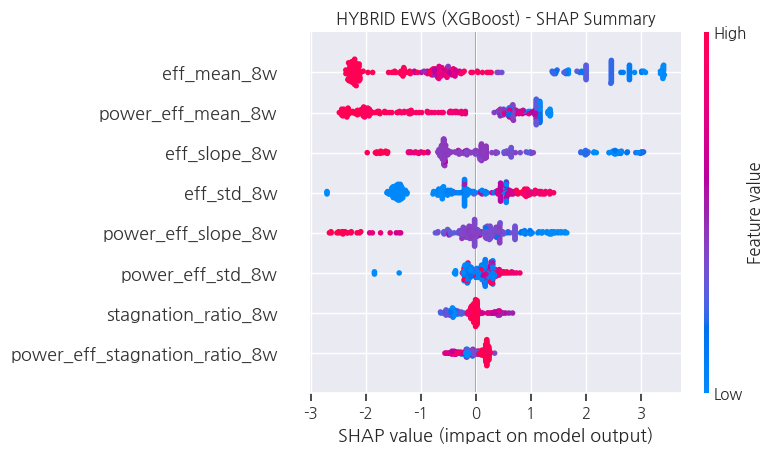

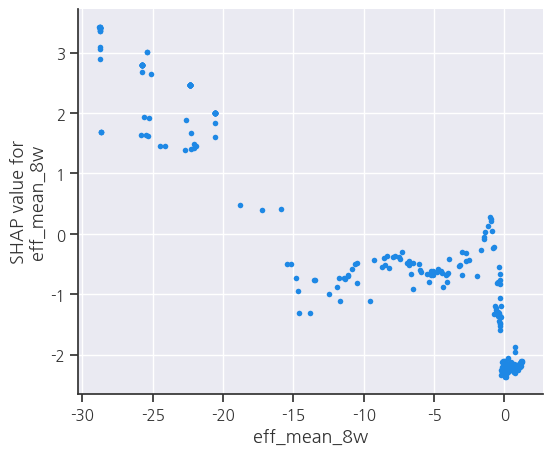

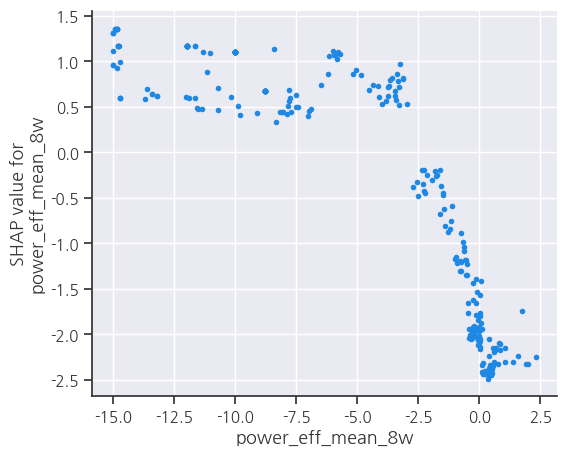

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap

# =========================================
# 1. EXP 기반 8주 스냅샷 만들기 (df_exp_snap)
#    - 예전에 EXP 가설에서 썼던 로직 그대로
# =========================================

snapshot_date = df['date'].max()
start_date = snapshot_date - pd.Timedelta(weeks=7)

df_win_exp = df[(df['date'] >= start_date) & (df['date'] <= snapshot_date)].copy()
df_win_exp['weeks_from_start'] = ((df_win_exp['date'] - start_date).dt.days // 7).astype(int)

def agg_user_exp(g):
    eff = g['eff'].values
    if len(eff) == 0:
        return pd.Series({
            'eff_mean_8w': np.nan,
            'eff_std_8w': np.nan,
            'eff_slope_8w': np.nan,
            'stagnation_ratio_8w': np.nan
        })
    x = g['weeks_from_start'].values.astype(float)
    if len(eff) > 1 and np.ptp(x) > 0:
        x_center = x - x.mean()
        slope = np.polyfit(x_center, eff, 1)[0]
    else:
        slope = 0.0

    return pd.Series({
        'eff_mean_8w': eff.mean(),
        'eff_std_8w': eff.std(ddof=0),
        'eff_slope_8w': slope,
        'stagnation_ratio_8w': np.mean(eff < 0)  # 로그정규화 기준
    })

df_exp_snap = df_win_exp.groupby("ocid", group_keys=False).apply(agg_user_exp)

# 이탈 라벨 붙이기 (기존 churn_flag 사용)
df_exp_snap["label"] = df_exp_snap.index.map(churn_flag).fillna(0).astype(int)

# 레벨 그룹 붙이기 (필요시 EDA용)
last_lg = (
    df.sort_values(["ocid","date"])
      .groupby("ocid").tail(1)
      .set_index("ocid")["level_group"]
)
df_exp_snap["level_group"] = df_exp_snap.index.map(last_lg)

df_exp_snap = df_exp_snap.reset_index()

print("df_exp_snap head:")
print(df_exp_snap.head())

# =========================================
# 2. EXP / SPEC / HYBRID 모델링용 DF 준비
# =========================================

# EXP 피처
exp_features = [
    "eff_mean_8w",
    "eff_std_8w",
    "eff_slope_8w",
    "stagnation_ratio_8w",
]

df_exp_base = (
    df_exp_snap[["ocid", "label"] + exp_features]
    .dropna(subset=exp_features + ["label"])
    .copy()
)
df_exp_base["label"] = df_exp_base["label"].astype(int)

# SPEC(전투력 효율) 피처
spec_features = [
    "power_eff_mean_8w",
    "power_eff_std_8w",
    "power_eff_slope_8w",
    "power_eff_stagnation_ratio_8w",
]

df_spec_base = (
    df_power_snap[["ocid", "label"] + spec_features]
    .dropna(subset=spec_features + ["label"])
    .copy()
)
df_spec_base["label"] = df_spec_base["label"].astype(int)

# HYBRID: EXP + SPEC 모두 있는 유저만 사용
df_hybrid = df_exp_base.merge(
    df_spec_base.drop(columns=["label"]),  # label은 EXP 기준 유지
    on="ocid",
    how="inner"
)

if "label_x" in df_hybrid.columns and "label_y" in df_hybrid.columns:
    assert (df_hybrid["label_x"] == df_hybrid["label_y"]).all()
    df_hybrid["label"] = df_hybrid["label_x"].astype(int)
    df_hybrid = df_hybrid.drop(columns=["label_x", "label_y"])
else:
    df_hybrid["label"] = df_hybrid["label"].astype(int)

hybrid_features = exp_features + spec_features

print("\n샘플 수 확인:")
print("EXP-only 샘플 수 :", len(df_exp_base))
print("SPEC-only 샘플 수:", len(df_spec_base))
print("HYBRID 샘플 수   :", len(df_hybrid))

# =========================================
# 3. 공통 train/test split (ocid 기준으로 고정)
# =========================================

ids = df_hybrid["ocid"].values
y_all = df_hybrid["label"].values

id_train, id_test, y_train, y_test = train_test_split(
    ids, y_all, test_size=0.3, random_state=42, stratify=y_all
)

id_train = pd.Index(id_train)
id_test  = pd.Index(id_test)

def get_X(df_base, feature_cols, id_index):
    """ocid 인덱스를 맞춰서 feature matrix 리턴"""
    return (
        df_base.set_index("ocid")
               .loc[id_index, feature_cols]
               .values
    )

X_exp_train    = get_X(df_exp_base,  exp_features,    id_train)
X_exp_test     = get_X(df_exp_base,  exp_features,    id_test)

X_spec_train   = get_X(df_spec_base, spec_features,   id_train)
X_spec_test    = get_X(df_spec_base, spec_features,   id_test)

X_hyb_train    = get_X(df_hybrid,    hybrid_features, id_train)
X_hyb_test     = get_X(df_hybrid,    hybrid_features, id_test)

print("\nX 모양 확인:")
print("X_exp_train   :", X_exp_train.shape)
print("X_spec_train  :", X_spec_train.shape)
print("X_hyb_train   :", X_hyb_train.shape)

# =========================================
# 4. 헬퍼 함수: Logistic / XGB 학습 + AUC 계산
# =========================================

def run_logistic(X_tr, X_te, y_tr, y_te):
    scaler = StandardScaler()
    X_tr_std = scaler.fit_transform(X_tr)
    X_te_std = scaler.transform(X_te)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_tr_std, y_tr)
    proba = clf.predict_proba(X_te_std)[:, 1]
    auc   = roc_auc_score(y_te, proba)
    return auc, clf, scaler, proba

def run_xgb(X_tr, X_te, y_tr, y_te):
    model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        tree_method="hist",
    )
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_te)[:, 1]
    auc   = roc_auc_score(y_te, proba)
    return auc, model, proba

# =========================================
# 5. EXP / SPEC / HYBRID 3셋팅에서 모델 돌리기
# =========================================

results = []

# 5-1) EXP-only
auc_exp_logit, logit_exp, scaler_exp, proba_exp_logit = run_logistic(
    X_exp_train, X_exp_test, y_train, y_test
)
auc_exp_xgb, xgb_exp, proba_exp_xgb = run_xgb(
    X_exp_train, X_exp_test, y_train, y_test
)
results.append(["EXP-only", "Logistic", auc_exp_logit])
results.append(["EXP-only", "XGBoost", auc_exp_xgb])

# 5-2) SPEC-only
auc_spec_logit, logit_spec, scaler_spec, proba_spec_logit = run_logistic(
    X_spec_train, X_spec_test, y_train, y_test
)
auc_spec_xgb, xgb_spec_h, proba_spec_xgb = run_xgb(
    X_spec_train, X_spec_test, y_train, y_test
)
results.append(["SPEC-only", "Logistic", auc_spec_logit])
results.append(["SPEC-only", "XGBoost", auc_spec_xgb])

# 5-3) HYBRID (EXP + SPEC)
auc_hyb_logit, logit_hyb, scaler_hyb, proba_hyb_logit = run_logistic(
    X_hyb_train, X_hyb_test, y_train, y_test
)
auc_hyb_xgb, xgb_hyb, proba_hyb_xgb = run_xgb(
    X_hyb_train, X_hyb_test, y_train, y_test
)
results.append(["HYBRID", "Logistic", auc_hyb_logit])
results.append(["HYBRID", "XGBoost", auc_hyb_xgb])

# =========================================
# 6. AUC 비교 표 출력
# =========================================

df_auc = pd.DataFrame(results, columns=["Setting", "Model", "Test_AUC"])
df_auc = df_auc.sort_values(["Setting", "Model"]).reset_index(drop=True)

print("\n=== EXP / SPEC / HYBRID AUC 비교 ===")
print(df_auc)

print("\n=== 피벗 형식 (행=Setting, 열=Model) ===")
print(df_auc.pivot(index="Setting", columns="Model", values="Test_AUC"))

# =========================================
# 7. HYBRID XGBoost SHAP 분석
# =========================================

shap.initjs()

X_hyb_test_df = pd.DataFrame(X_hyb_test, columns=hybrid_features)

explainer_hyb = shap.TreeExplainer(xgb_hyb)
shap_values_hyb = explainer_hyb.shap_values(X_hyb_test_df)

# 7-1. 중요도 bar plot
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values_hyb, X_hyb_test_df, plot_type="bar", show=False)
plt.title("HYBRID EWS (XGBoost) - SHAP Feature Importance")
plt.tight_layout()
plt.show()

# 7-2. beeswarm summary
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values_hyb, X_hyb_test_df, show=False)
plt.title("HYBRID EWS (XGBoost) - SHAP Summary")
plt.tight_layout()
plt.show()

# EXP vs SPEC 평균효율 개별 dependence plot
shap.dependence_plot("eff_mean_8w", shap_values_hyb, X_hyb_test_df, interaction_index=None)
shap.dependence_plot("power_eff_mean_8w", shap_values_hyb, X_hyb_test_df, interaction_index=None)
